# ТЕМА 3. КОГНИТИВНЫЕ ПОДХОДЫ, СИСТЕМЫ И СЕРВИСЫ В ЦИФРОВОМ БИЗНЕСЕ

В рамках данной лабораторной работы рассматривается практическое применение когнитивных подходов (в данном случае методов машинного зрения) на примере анализа и обработки изображений с помощью предобученной нейронной сети VGG16. Будет показано, как можно извлечь признаки из изображений, проанализировать их сходство и затем использовать полученные данные для улучшения пользовательского опыта и эффективности рекомендательных систем.

**Задания:**

***3) Изучение технологии transfer learning:***

Ознакомьтесь с технологией transfer learning (переносное обучение) на примере файла transfer_learning.ipynb.

Исследуйте, как предварительно обученные модели могут быть адаптированы для решения новых задач с меньшим количеством данных.

***4) Классификация изображений с использованием transfer learning:***

Используйте технологию transfer learning для решения задачи классификации изображений (муравьи и пчелы).

Проведите эксперименты с различными настройками нейросети и архитектурами предварительно обученных моделей для улучшения результатов.

Оцените эффективность transfer learning по сравнению с обучением модели с нуля.

**Transfer Learning** - это процесс дообучения на новых данных какой-либо нейросети, уже обученной до этого на других данных, обычно на каком-нибудь хорошем, большом (миллионы картинок) датасете (например, ImageNet ~ 14 млн картинок).

## Задание

Вам предстоит попробовать использовать типа архитектур свёрточных нейросетей - AlexNet (сделано за Вас в примере), VGG16, Inception_v3 - как Feature Extractor, с помощью Fine Tuning и *"из коробки"*.

Для каждого пункта нужно:

вывести график loss'а на обучающей и на валидационной выборке

вывести качество модели (accuracy)

### Данные  

В данном задании используются сети (из библиотеки **torchvision**), предобученные на датасете ImageNet.  
В качестве новых данных будет датасет Меравьи vs Пчёлы, Вам нужно скачать его отсюда: **[Муравьи vs Пчёлы](https://download.pytorch.org/tutorial/hymenoptera_data.zip)**, *являющийся частью датасета ImageNet*. В нём 400 картинок, ~250 обучение и ~150 валидация (тест).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

### Функции для отрисовки и обучения модели:

In [4]:
# Загрузим данные:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными
data_dir = '/content/drive/MyDrive/Colab Notebooks/Предиктивная аналитика больших данных/Lab_3/images/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# Размеры обучающей и валидационной выборок:
print(dataset_sizes)

{'train': 244, 'val': 153}


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


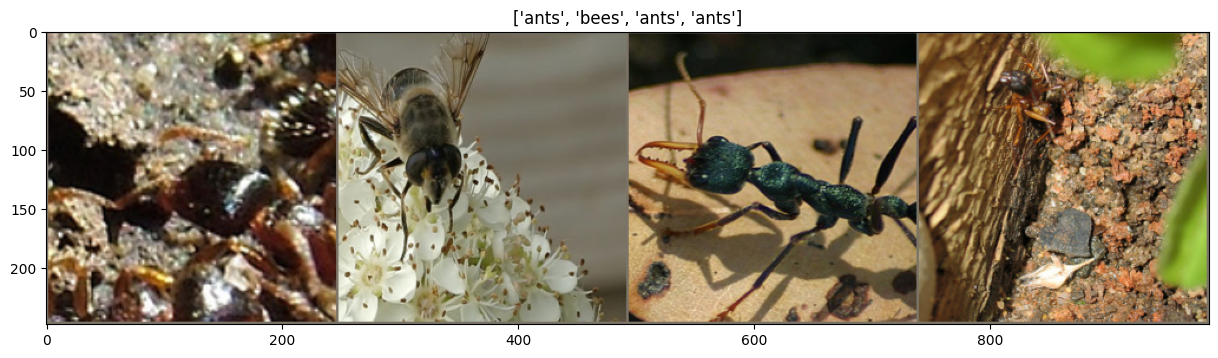

In [6]:
# Посмотрим на картинки из датасета:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[1.7352, 1.7352, 1.7352,  ..., 1.7009, 1.7009, 1.7009],
         [1.7523, 1.7523, 1.7523,  ..., 1.7523, 1.7180, 1.7009],
         [1.7523, 1.7523, 1.7523,  ..., 1.7180, 1.7180, 1.7009],
         ...,
         [1.7865, 1.7865, 1.7865,  ..., 1.6324, 1.6667, 1.7009],
         [1.7865, 1.7865, 1.7865,  ..., 1.6495, 1.6667, 1.7009],
         [1.7865, 1.7865, 1.7865,  ..., 1.6667, 1.6838, 1.7180]],

        [[1.9034, 1.9034, 1.9034,  ..., 1.8508, 1.8508, 1.8508],
         [1.9034, 1.9034, 1.9034,  ..., 1.8508, 1.8333, 1.8508],
         [1.9034, 1.9034, 1.9034,  ..., 1.8683, 1.8333, 1.8508],
         ...,
         [1.9559, 1.9559, 1.9559,  ..., 1.7983, 1.8333, 1.8683],
         [1.9559, 1.9559, 1.9559,  ..., 1.8158, 1.8333, 1.8683],
         [1.9559, 1.9559, 1.9559,  ..., 1.8333, 1.8508, 1.8859]],

        [[2.0823, 2.0823, 2.0823,  ..., 1.9777, 1.9777, 1.9777],
         [2.0823, 2.0823, 2.0823,  ..., 2.0125, 1.9951, 1.9951],
         [2.0823, 2.0823, 2.0823,  ..., 2.0125, 1.9951, 1.

### Обучение моделей

### ***Задание_1***

 Вам нужно модифицировать эту функцию, чтобы она возвращала ещё и массивы loss'а на обучающей и валидационной выборках (чтобы потом Вы могли нарисовать графики). Можете модифицировать эту функцию как угодно, лишь бы она правильно работала.

In [8]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = model.state_dict()
#     best_acc = 0.0

#     #Ваш код здесь
#     losses = {'train': [], 'val': []}

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # каждя эпоха имеет обучающую и тестовую стадии
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 scheduler.step()
#                 model.train(True)  # установаить модель в режим обучения
#             else:
#                 model.train(False)  # установить модель в режим предсказания

#             running_loss = 0.0
#             running_corrects = 0

#             # итерируемся по батчам
#             for data in dataloaders[phase]:
#                 # получаем картинки и метки
#                 inputs, labels = data

#                 # оборачиваем в переменные
#                 if use_gpu:
#                     inputs = inputs.cuda()
#                     labels = labels.cuda()
#                 else:
#                     inputs, labels = inputs, labels

#                 # инициализируем градиенты параметров
#                 optimizer.zero_grad()

#                 # forward pass
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs.data, 1)
#                 loss = criterion(outputs, labels)

#                 # backward pass + оптимизируем только если это стадия обучения
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#                 # статистика
#                 running_loss += loss.item()
#                 running_corrects += int(torch.sum(preds == labels.data))

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects / dataset_sizes[phase]

#             # Ваш код здесь
#             losses[phase].append(epoch_loss)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # если достиглось лучшее качество, то запомним веса модели
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = model.state_dict()

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # загрузим лучшие веса модели
#     model.load_state_dict(best_model_wts)
#     return model, losses

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_losses = []  # Массив для отслеживания потерь на обучающей выборке
    val_losses = []    # Массив для отслеживания потерь на валидационной выборке

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждая эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Сохраняем потери для текущей фазы
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses


***В этой модифицированной версии функции train_model я внес несколько изменений:***

1)Добавлены переменные train_losses и val_losses: Я добавил две новые переменные, чтобы отслеживать потери на обучающей и валидационной выборках во время обучения модели.

2)Сохранение потерь в массивы: В каждой эпохе потери для обучающей и валидационной выборок сохраняются в соответствующие массивы train_losses и val_losses.

3)Возвращение массивов потерь: После завершения обучения функция возвращает модель вместе с массивами потерь на обучающей и валидационной выборках.

4)Изменения в возвращаемом значении функции: Теперь функция возвращает три значения: модель, массив потерь на обучающей выборке и массив потерь на валидационной выборке.

* Функция для отрисовки тестовых изображений и предсказаний для них:

In [10]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

* Функция для измерения точности модели на валидационном датасете

In [11]:
def evaluate(model):
    model.train(False)

    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data

        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)

        runninig_correct += int(torch.sum(predicted == labels))

    return runninig_correct / dataset_sizes['val']

### ***Задание_2***

Для каждой из следующих нейросетей:
* **AlexNet**
* **VGG16**
* **Inception_v3**

Напишите код и выведите результат (график лосса, accuracy и вывод примера классификации картинок с визализацией (с помощью функции `vizualize_model()`)) для трёх способов:
* Использование готовой нейросети **"из коробки"**
* Использование нейросети как **Feature Extractor**
* **Fine Tuning** нейросети

Для каждого пункта нужно:
* сделать с сетью то, что нужно в пункте ("из коробки", FE или FT)
* вывести график loss'а на обучающей и на валидационной выборке
* вывести качество модели (accuracy) на валидационной (тестовой) выборке
* (по желанию) использовать функцию visualize_model()

#### **AlexNet:**

In [12]:
# Загрузка модели:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 45.8MB/s]


In [13]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видим, что на вход классификатору (classifier) подаётся 9216 признаков. Это и будет размер входа для нашего нового классификатора.

* **Fine Tuning** способ

Сконфигурируем - изменим FC-слой и зададим *cost function* и *оптимизирующий алгоритм*:

(*по умолчанию backpropagation распространяется на все слои, поэтому здесь мы только заменяем FC-слой на свой классификатор*)

In [14]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model, train_losses, val_losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2841 Acc: 0.5369
val Loss: 0.1811 Acc: 0.5621

Epoch 1/24
----------
train Loss: 0.1737 Acc: 0.5574
val Loss: 0.1896 Acc: 0.4706

Epoch 2/24
----------
train Loss: 0.1670 Acc: 0.5820
val Loss: 0.1786 Acc: 0.5163

Epoch 3/24
----------
train Loss: 0.1650 Acc: 0.6189
val Loss: 0.1839 Acc: 0.5359

Epoch 4/24
----------
train Loss: 0.1667 Acc: 0.5943
val Loss: 0.1749 Acc: 0.5163

Epoch 5/24
----------
train Loss: 0.1882 Acc: 0.5697
val Loss: 0.1798 Acc: 0.4575

Epoch 6/24
----------
train Loss: 0.1707 Acc: 0.5082
val Loss: 0.1797 Acc: 0.4510

Epoch 7/24
----------
train Loss: 0.1698 Acc: 0.5164
val Loss: 0.1793 Acc: 0.4706

Epoch 8/24
----------
train Loss: 0.1689 Acc: 0.5451
val Loss: 0.1745 Acc: 0.5490

Epoch 9/24
----------
train Loss: 0.1668 Acc: 0.5697
val Loss: 0.1716 Acc: 0.5817

Epoch 10/24
----------
train Loss: 0.1625 Acc: 0.6516
val Loss: 0.1690 Acc: 0.5948

Epoch 11/24
----------
train Loss: 0.1649 Acc: 0.6311
val Loss: 0.1636 Acc: 0.6601

Epoch 12/24
----------
t

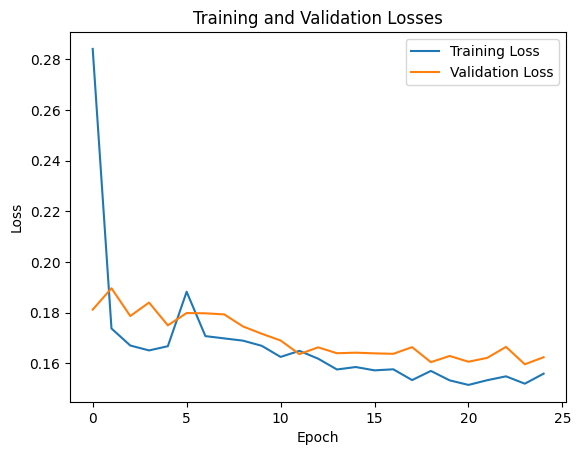

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

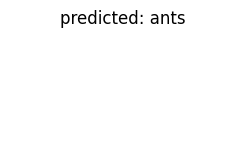

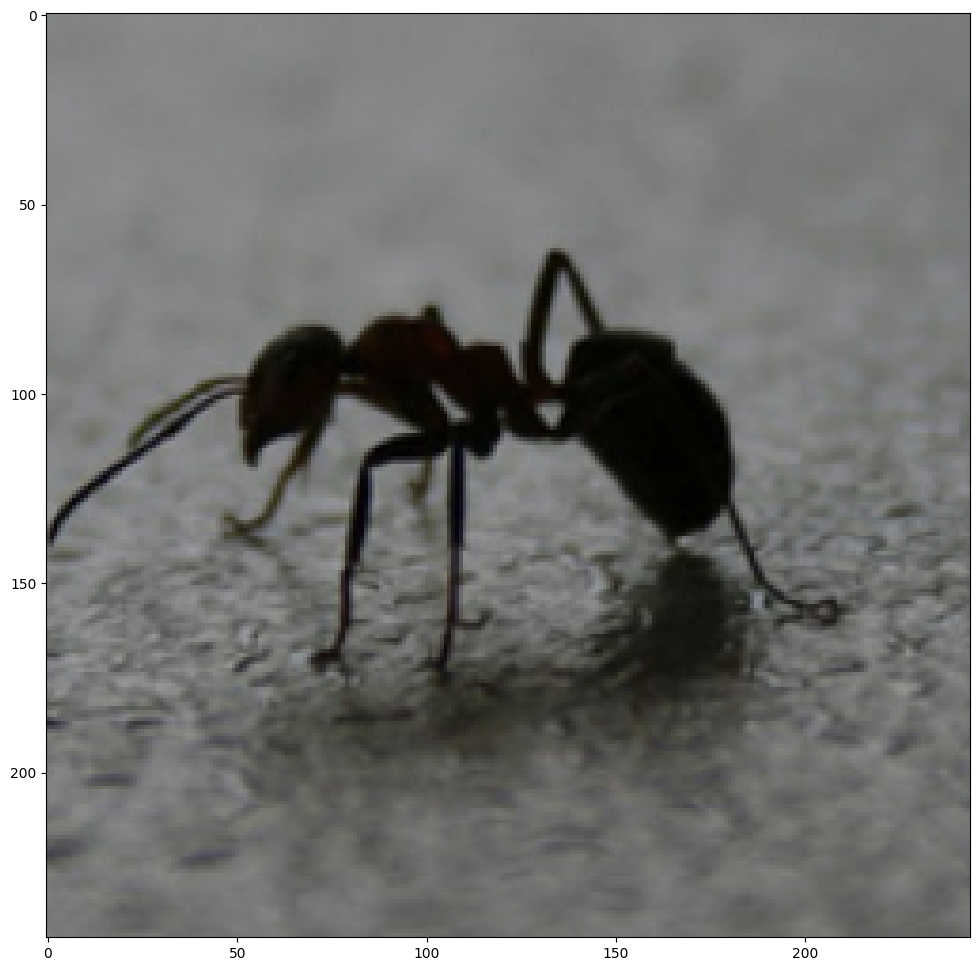

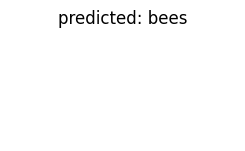

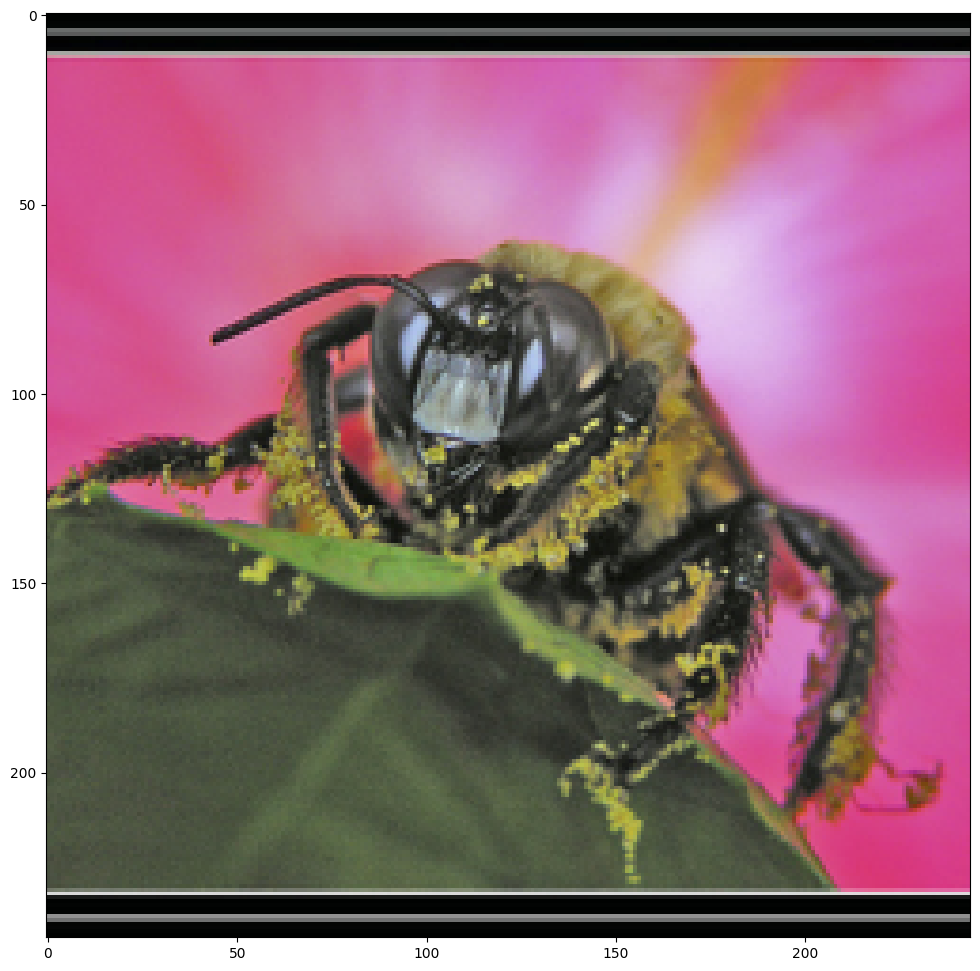

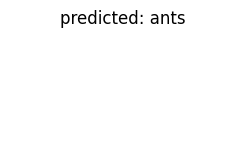

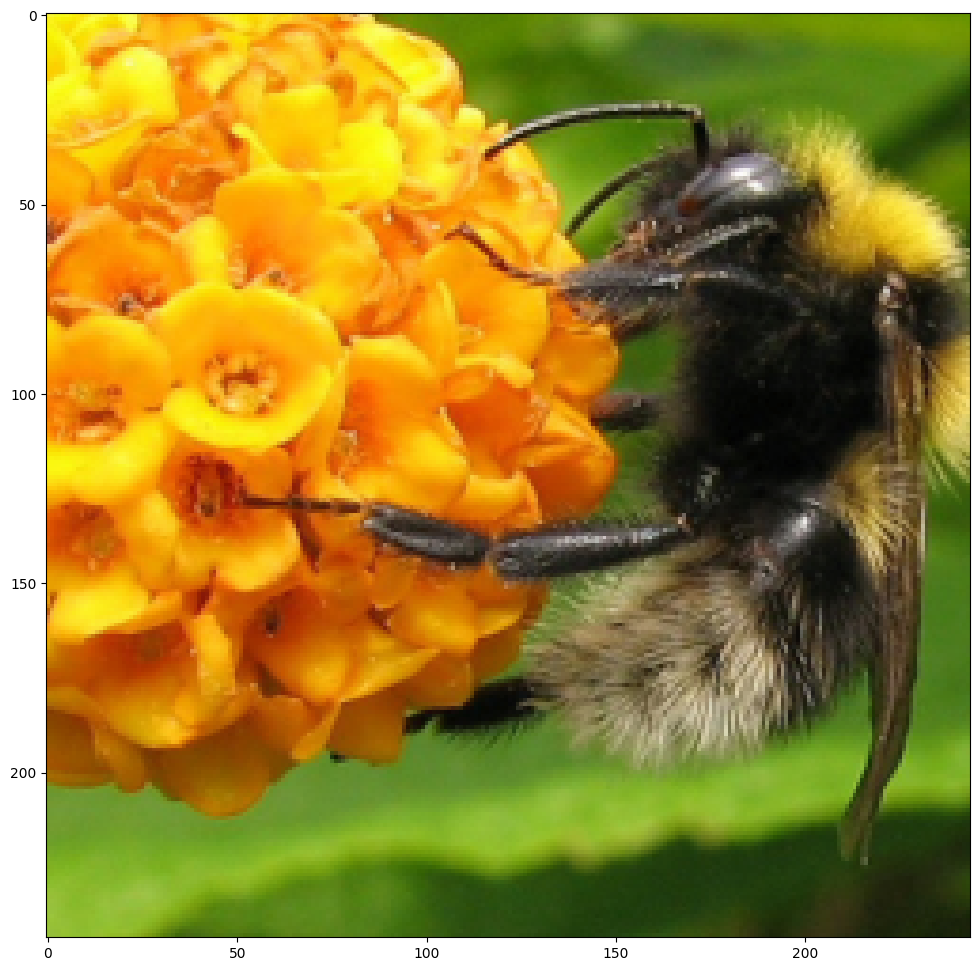

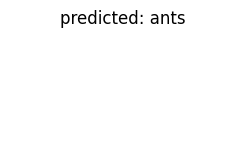

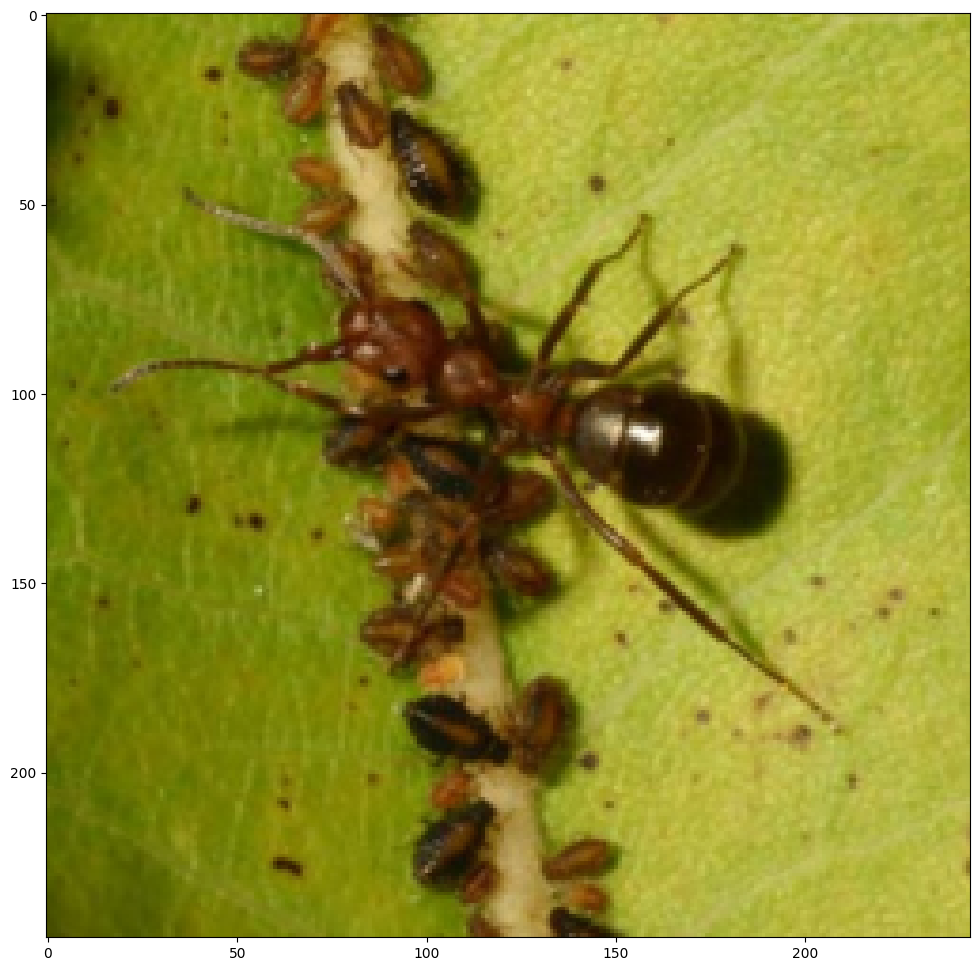

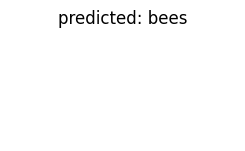

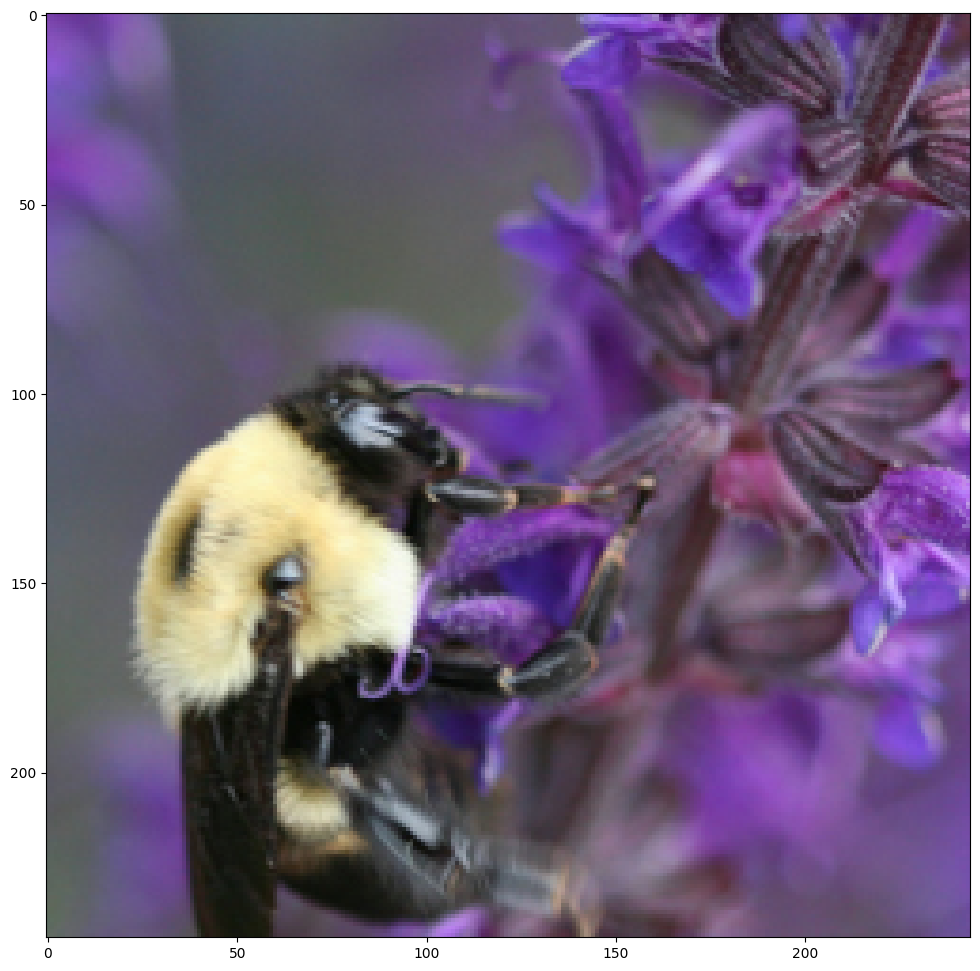

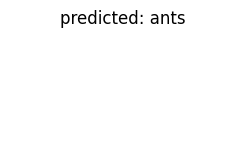

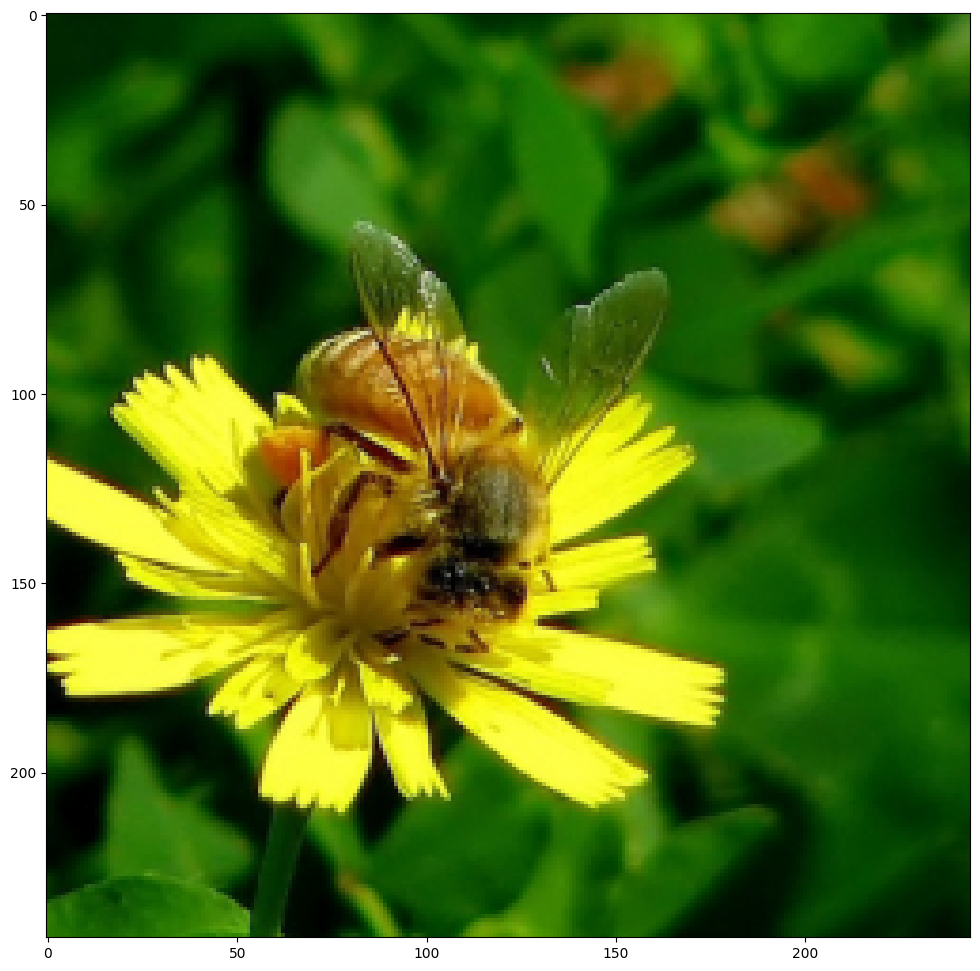

In [17]:
# Используем функцию visualize_model() для визуализации результатов
visualize_model(model)

In [18]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [19]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [20]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.6863


Оценка модели - 68 %, что маловато для свёрточной нейросети для задачи классификации картинок. Посмотрим, как будет с AlexNet в роли Feature Extractor'a

* **Feature Extractor** способ:

In [21]:
model_extractor = models.alexnet(pretrained=True)

In [22]:
# Помним, что по-умолчанию все слои нейросети обучаются заново:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [23]:
# Сделаем так, чтобы на них не распространялся backpropagation (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).


In [24]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
%%time
model_extractor, train_losses, val_losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1951 Acc: 0.7172
val Loss: 3.1141 Acc: 0.6863

Epoch 1/24
----------
train Loss: 0.6351 Acc: 0.8975
val Loss: 1.1272 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.7492 Acc: 0.8893
val Loss: 1.3322 Acc: 0.8301

Epoch 3/24
----------
train Loss: 1.0215 Acc: 0.8402
val Loss: 1.4799 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.6777 Acc: 0.8648
val Loss: 0.9137 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.8928 Acc: 0.8443
val Loss: 1.5373 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4607 Acc: 0.8730
val Loss: 0.9933 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3981 Acc: 0.9139
val Loss: 1.0157 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.5332 Acc: 0.8934
val Loss: 1.0010 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.4474 Acc: 0.9098
val Loss: 1.0308 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2418 Acc: 0.9221
val Loss: 0.9462 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.3498 Acc: 0.9180
val Loss: 0.9957 Acc: 0.8889

Ep

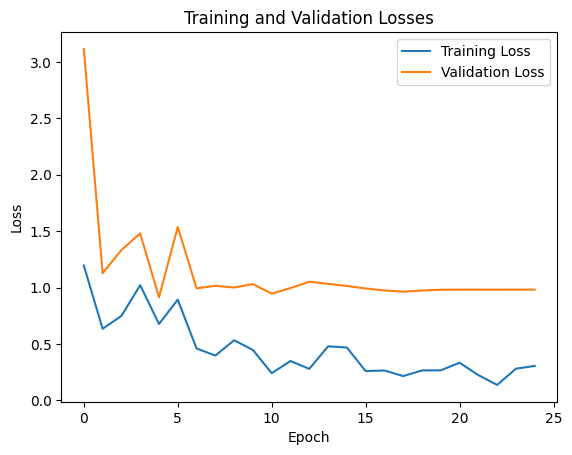

In [26]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

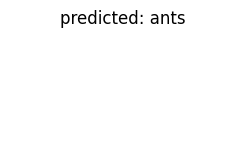

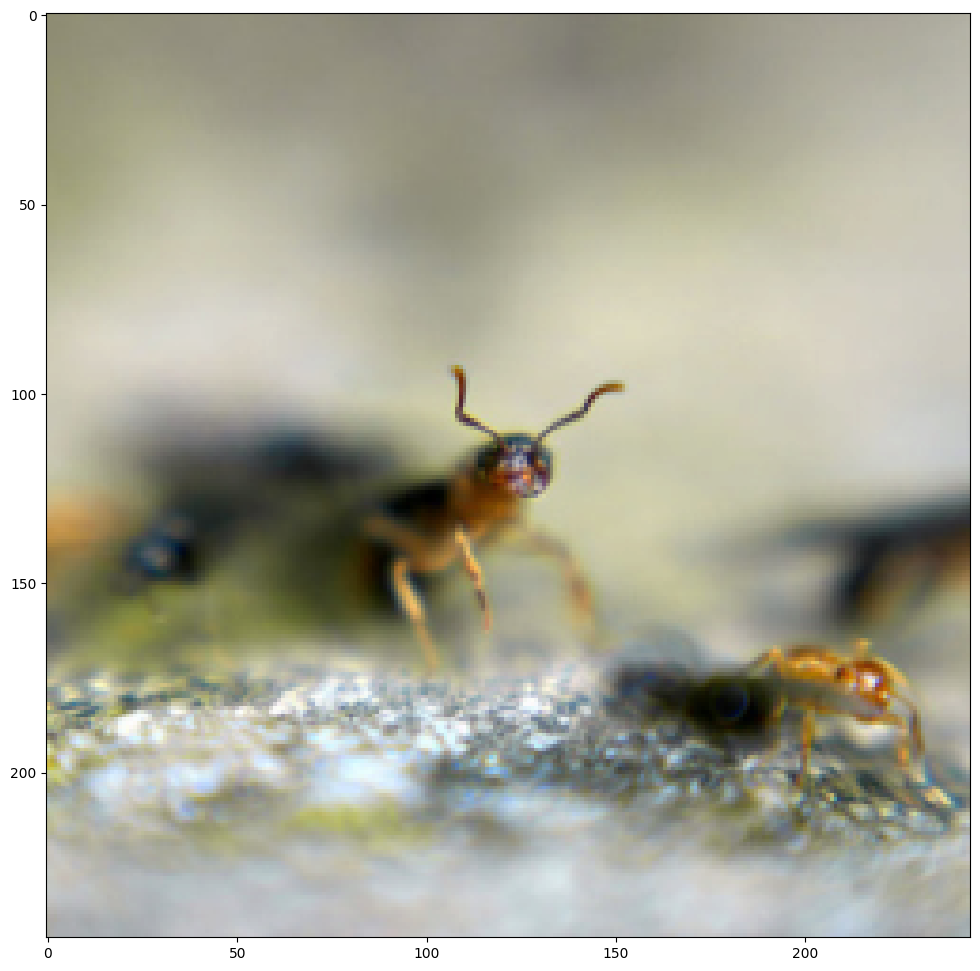

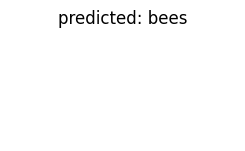

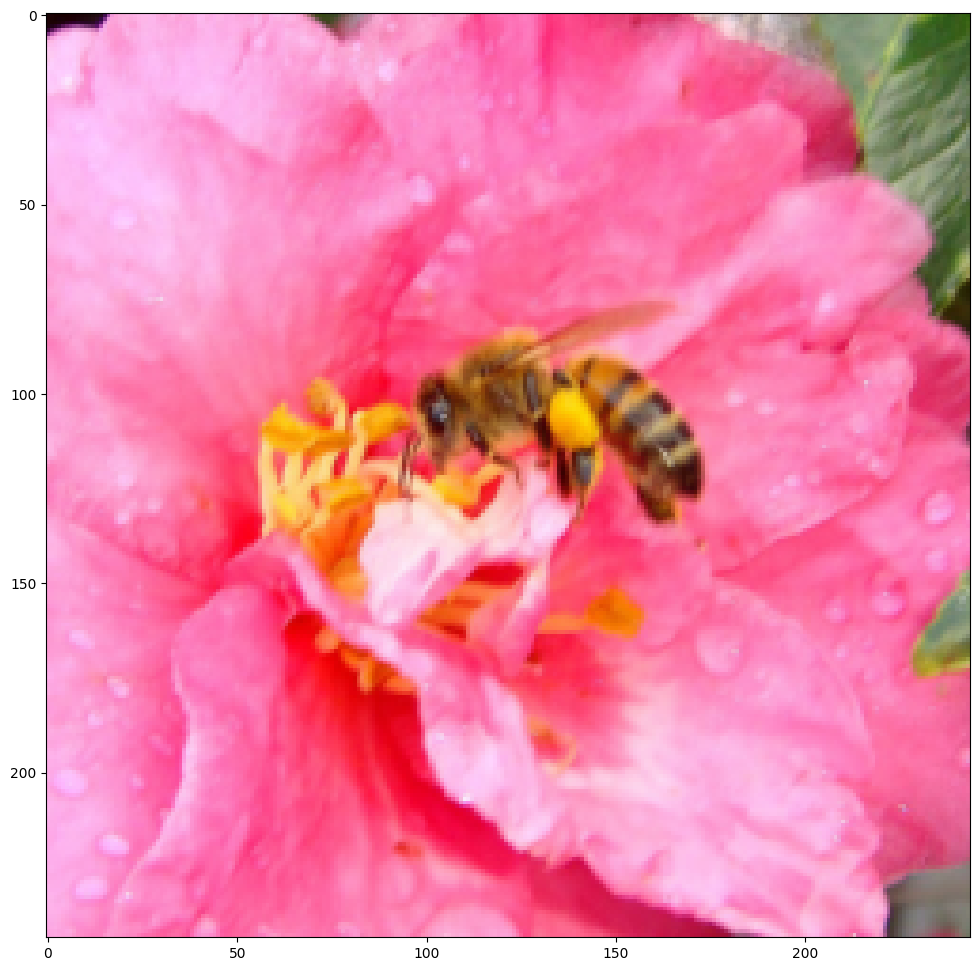

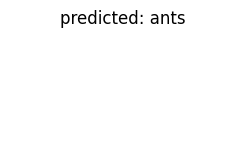

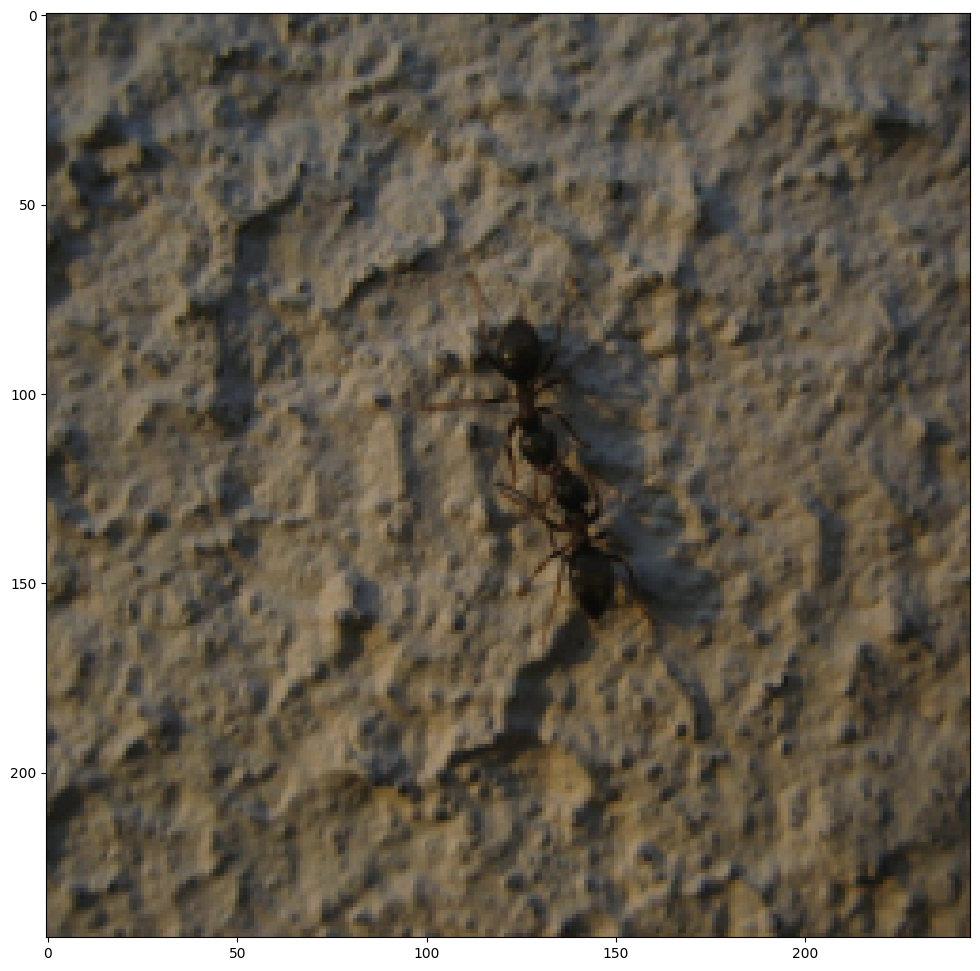

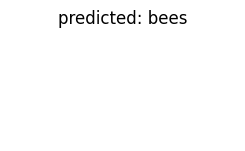

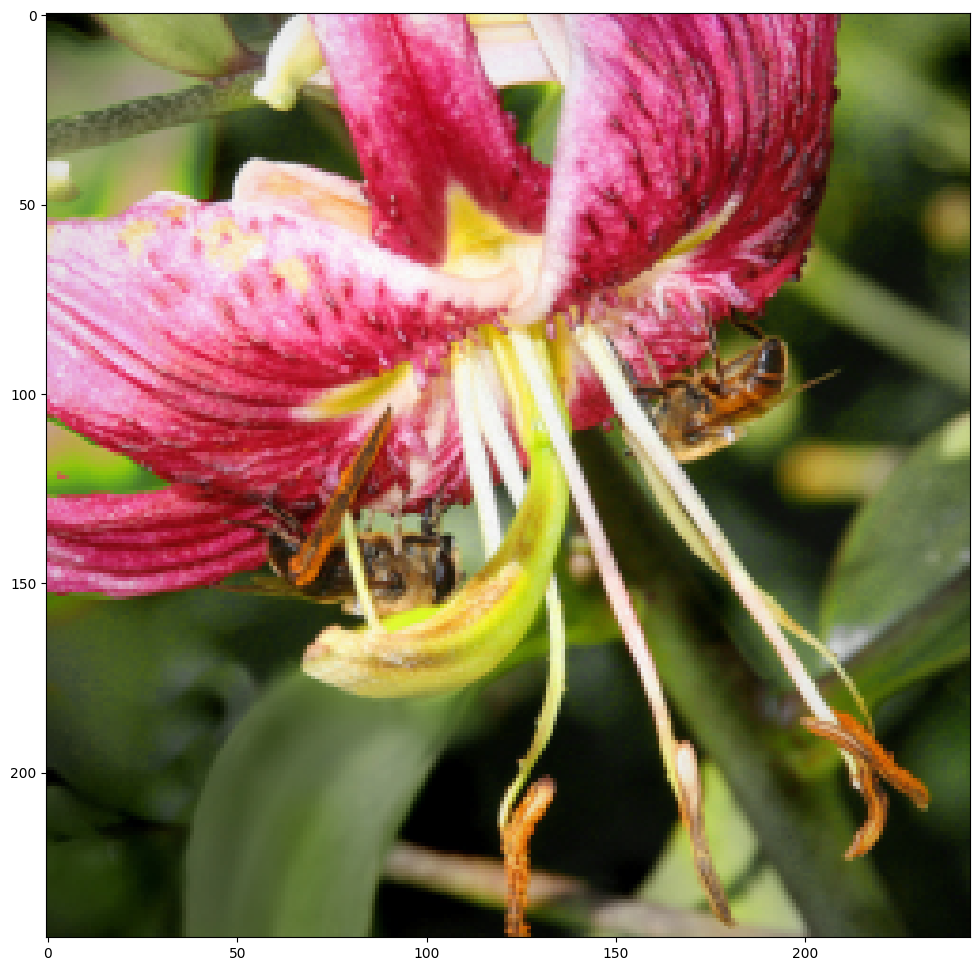

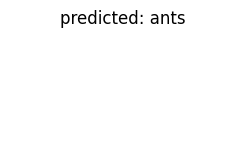

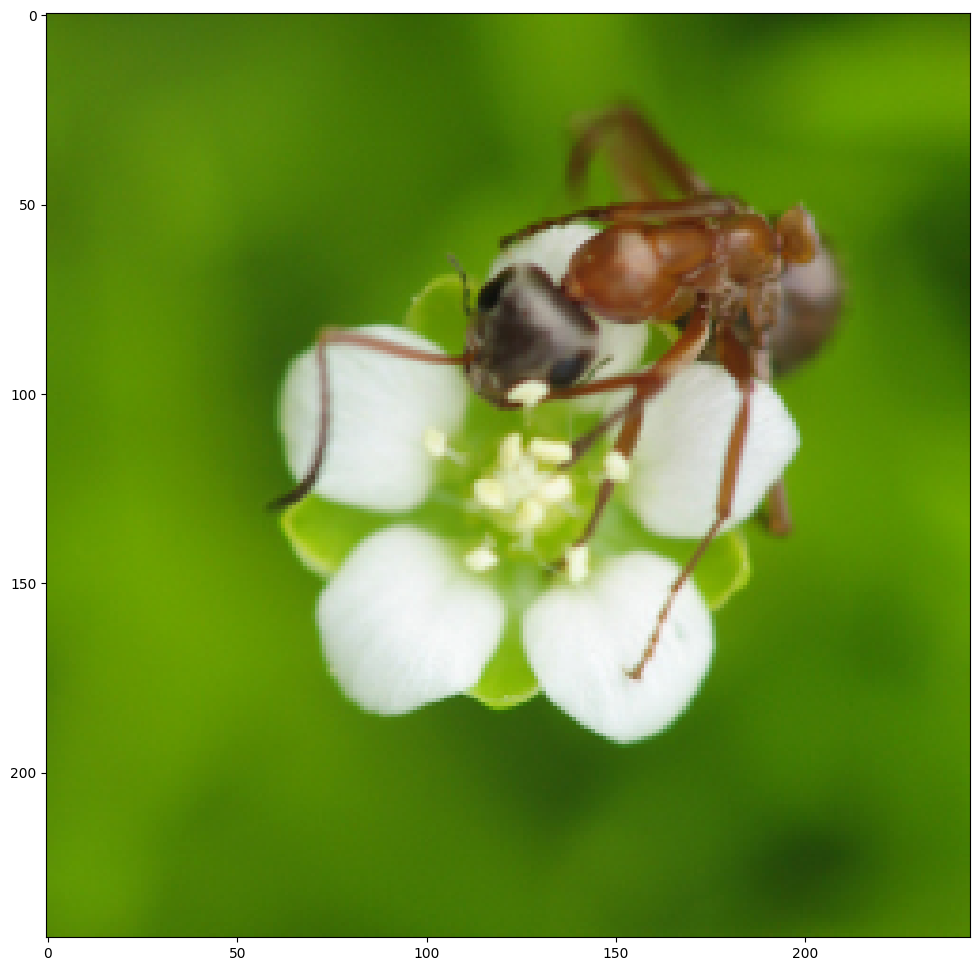

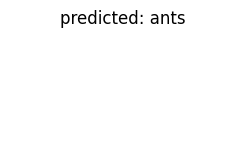

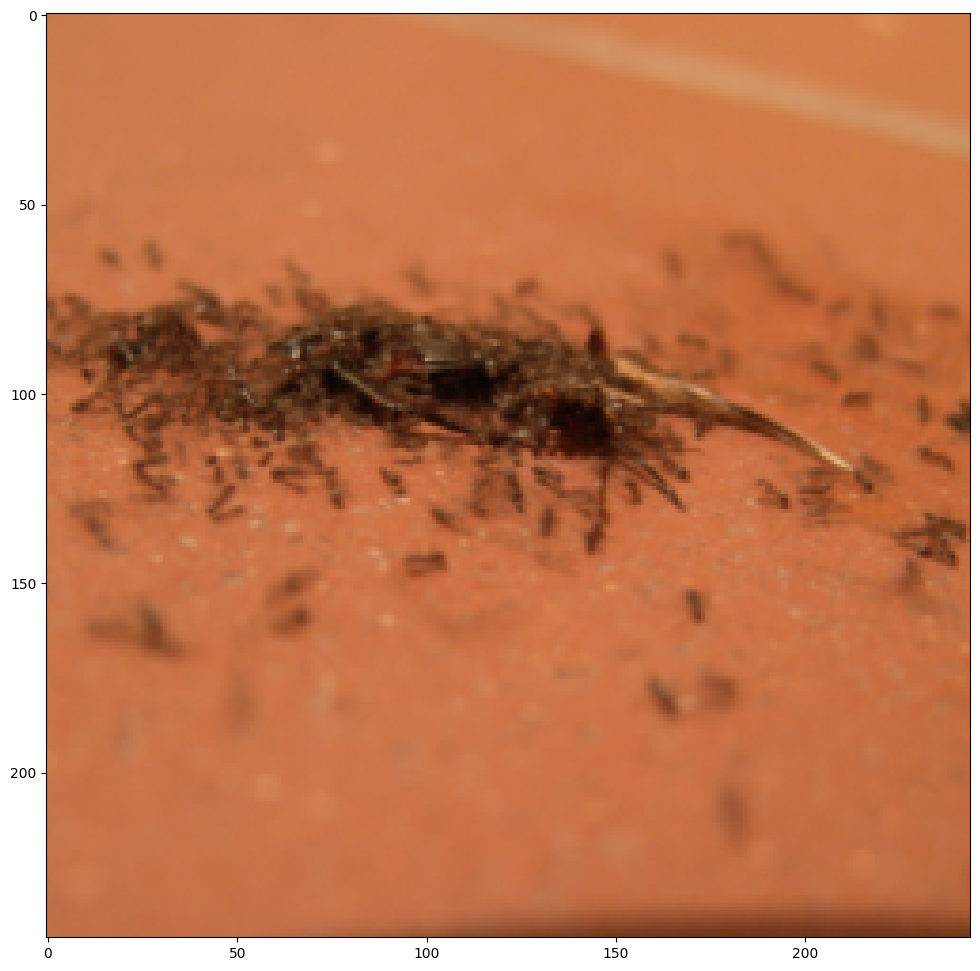

In [27]:
# Используем функцию visualize_model() для визуализации результатов
visualize_model(model_extractor)

In [28]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [29]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [30]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.8889


Видим, что качество намного лучше: ~90%.

* **Смешанный** способ:
Мы будем обучать не только последний **fully connected** слой, но и несколько предпоследних

In [31]:
model_mixed = models.alexnet(pretrained=True)

In [32]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] +
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
%%time
_, train_losses, val_losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4136 Acc: 0.6967
val Loss: 0.1820 Acc: 0.7386

Epoch 1/24
----------
train Loss: 0.1328 Acc: 0.8115
val Loss: 0.1376 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.1179 Acc: 0.7992
val Loss: 0.1147 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.0981 Acc: 0.8361
val Loss: 0.1119 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.0765 Acc: 0.8811
val Loss: 0.0945 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.0945 Acc: 0.8648
val Loss: 0.2154 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.0866 Acc: 0.8770
val Loss: 0.1200 Acc: 0.8366

Epoch 7/24
----------
train Loss: 0.0601 Acc: 0.8852
val Loss: 0.1171 Acc: 0.8431

Epoch 8/24
----------
train Loss: 0.0460 Acc: 0.9057
val Loss: 0.1147 Acc: 0.8497

Epoch 9/24
----------
train Loss: 0.0614 Acc: 0.8975
val Loss: 0.1103 Acc: 0.8693

Epoch 10/24
----------
train Loss: 0.0498 Acc: 0.9016
val Loss: 0.1216 Acc: 0.8366

Epoch 11/24
----------
train Loss: 0.0578 Acc: 0.9139
val Loss: 0.1123 Acc: 0.8627

Ep

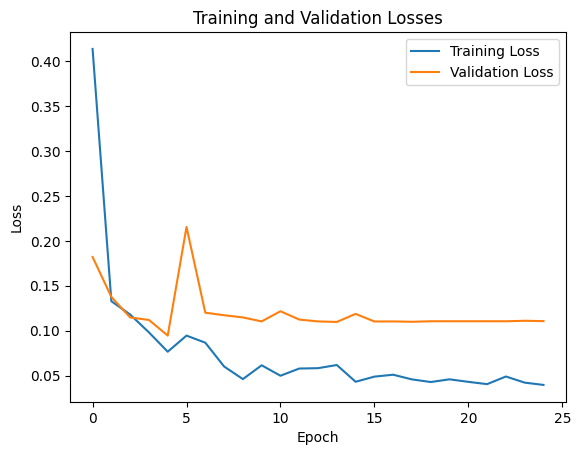

In [34]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

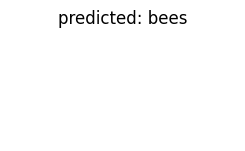

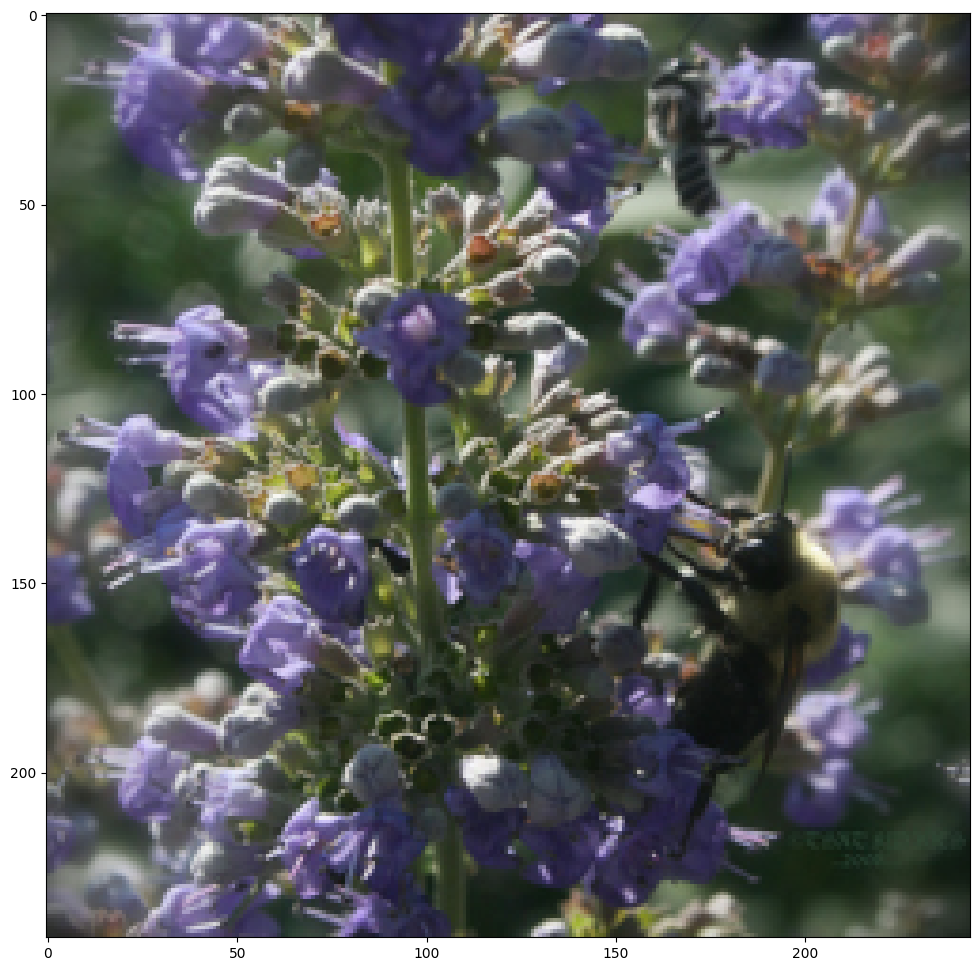

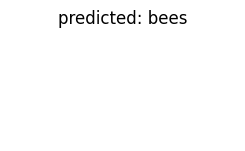

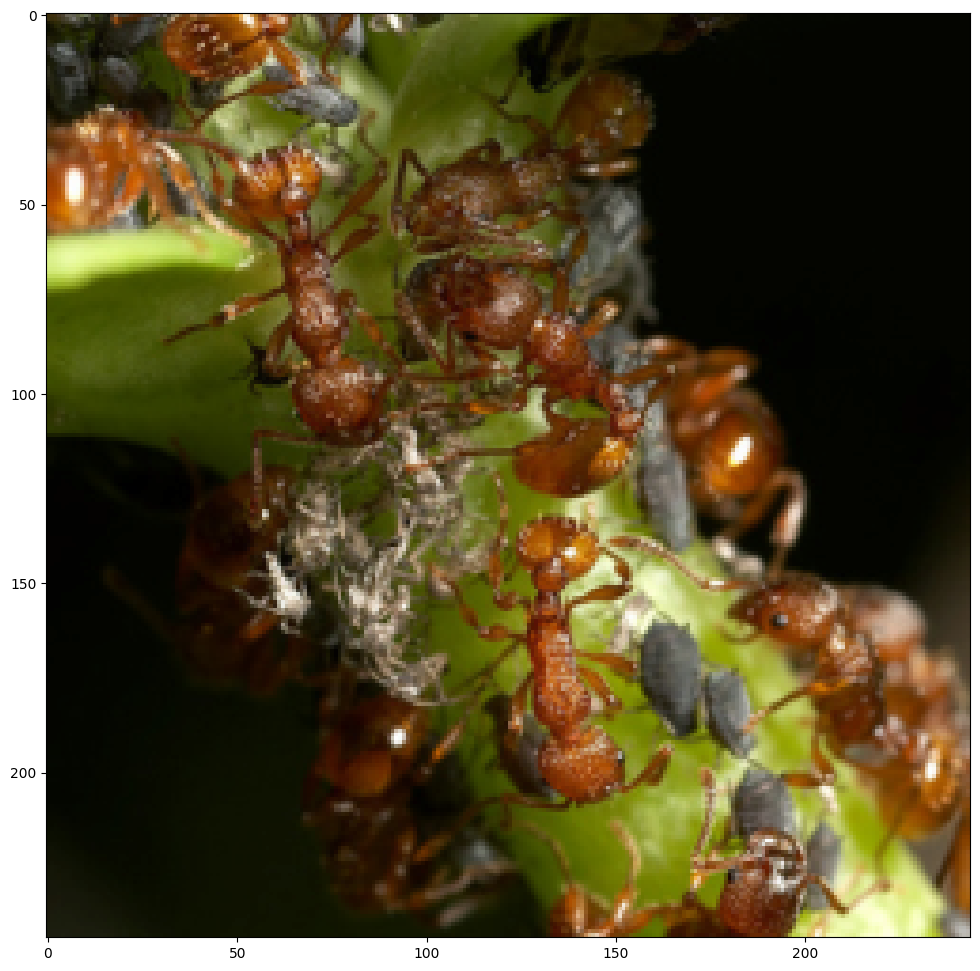

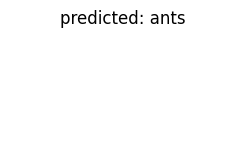

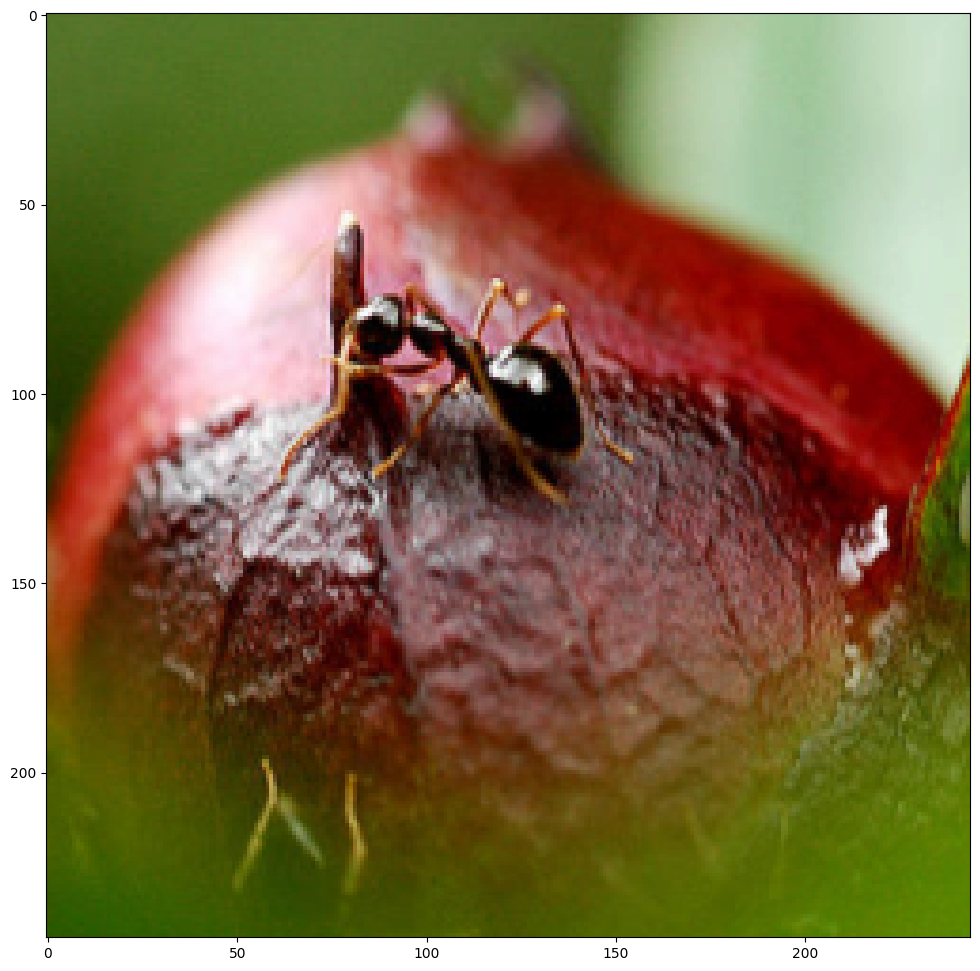

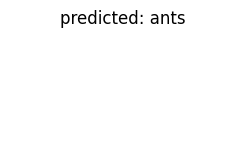

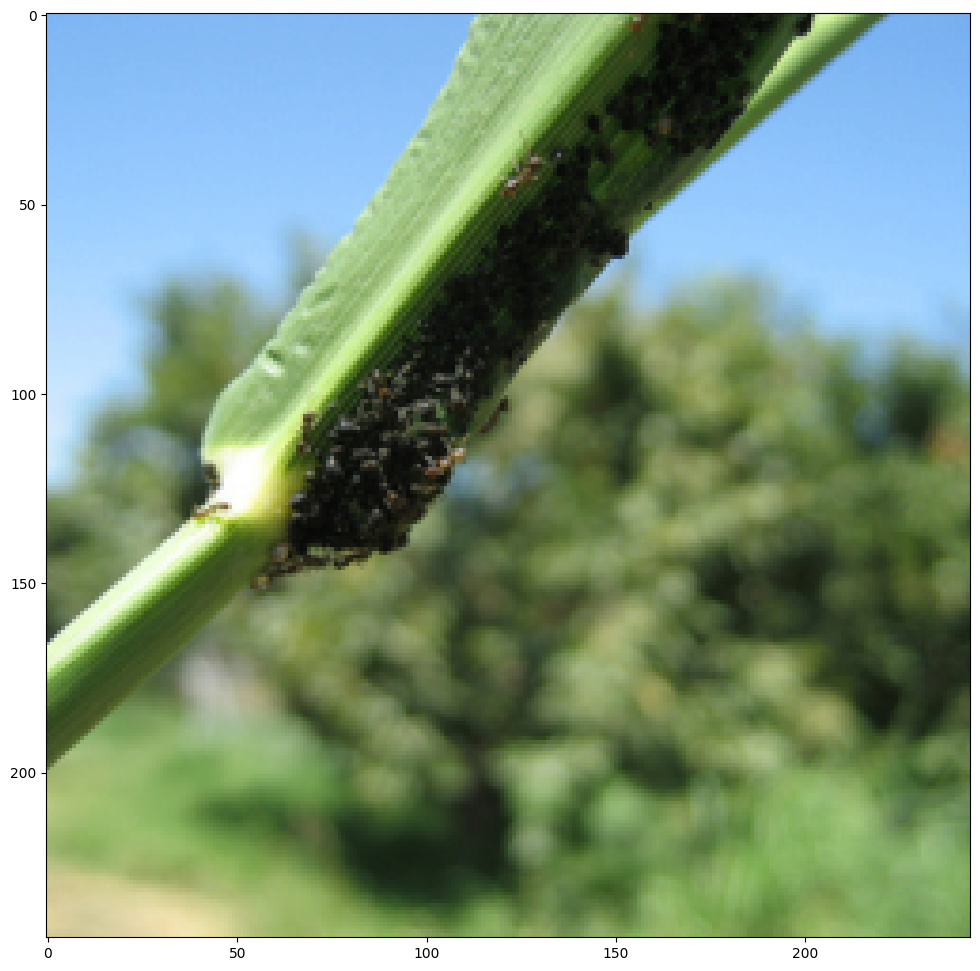

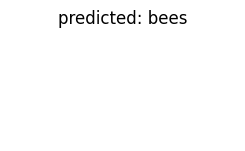

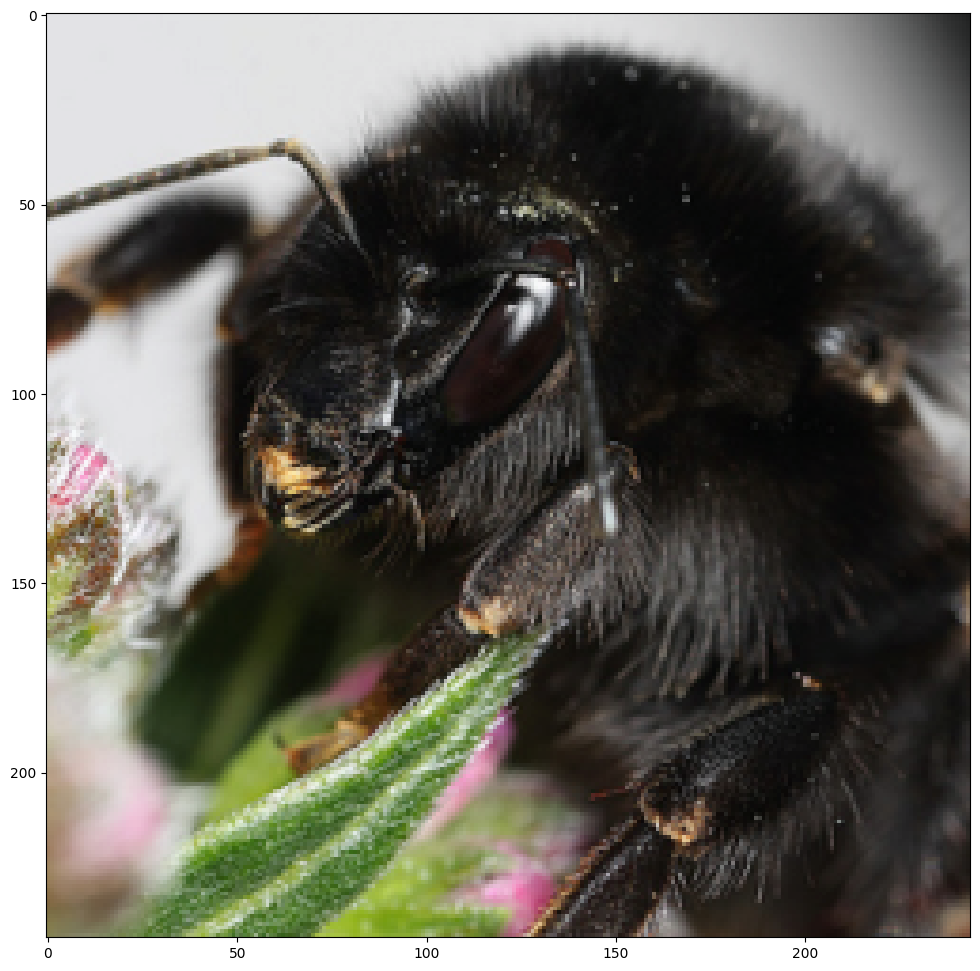

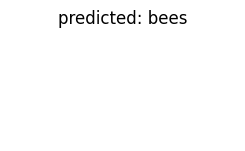

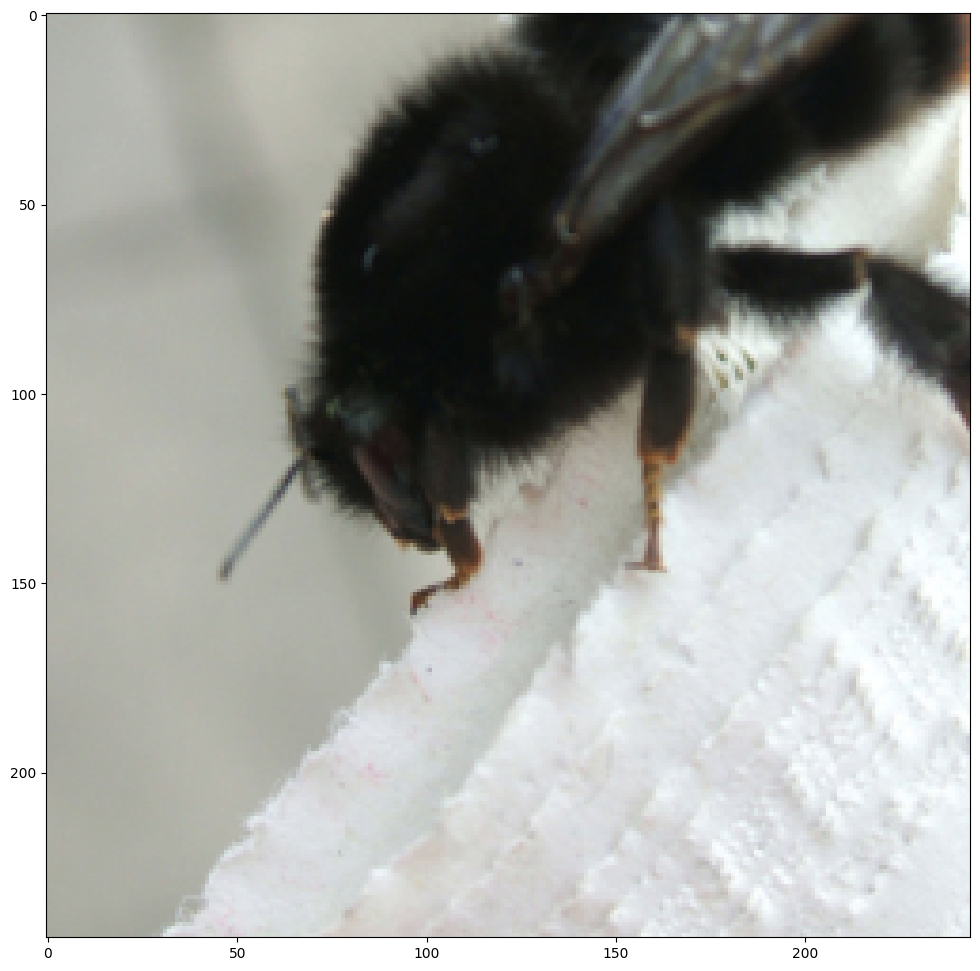

In [35]:
# Используем функцию visualize_model() для визуализации результатов
visualize_model(model_mixed)

In [36]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [37]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

<All keys matched successfully>

In [38]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

Accuracy: 0.8562


**Вопрос 1 (важный):** С чем связано повышение качества если мы перестаем учить всю сеть? (Подсказка: посмотрите на датасет и на то, как он согласуется с 4-мя ситуациями, описанными выше)

Ответ: Характеристики нашего набора данных существенно совпадают с теми, на которых была обучена предварительно-обученная модель. Она уже содержит высокоуровневые признаки, которые могут быть нам полезны. Использование предварительно обученных слоев как Feature Extractor позволяет извлечь полезные признаки из предварительно обученной модели, что улучшает обобщающую способность модели на небольшом наборе данных.

**Вопрос 2**: Почему разморозка последних слоев не дает прироста к точности, хотя разморозить несколько послдних слоев обычно хорошеее решение для классификации похожего датасета? (Вопрос на внимательность)

Вероятнее всего  размораживание дополнительных слоев приводит к переобучению модели, вдобавок количество обучающих данных сильно ограничено. Если данных недостаточно для эффективного обучения всех параметров модели, размораживание последних слоев может привести к излишней сложности модели и переобучению на обучающих данных.

### **VGG16**

In [39]:
# Объявляем модель
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.4MB/s]


In [40]:
# Запускаем обучение

model_extractor, train_losses, val_losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5925 Acc: 0.7705
val Loss: 0.5914 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.6692 Acc: 0.8566
val Loss: 0.4610 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4843 Acc: 0.9098
val Loss: 0.6530 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3384 Acc: 0.9344
val Loss: 0.3954 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.1979 Acc: 0.9385
val Loss: 0.6416 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.2709 Acc: 0.9057
val Loss: 0.6362 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.2646 Acc: 0.9303
val Loss: 0.5509 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.1931 Acc: 0.9426
val Loss: 0.5157 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0573 Acc: 0.9795
val Loss: 0.5197 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.1144 Acc: 0.9631
val Loss: 0.5229 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2272 Acc: 0.9385
val Loss: 0.5570 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.0563 Acc: 0.9877
val Loss: 0.5739 Acc: 0.9477

Ep

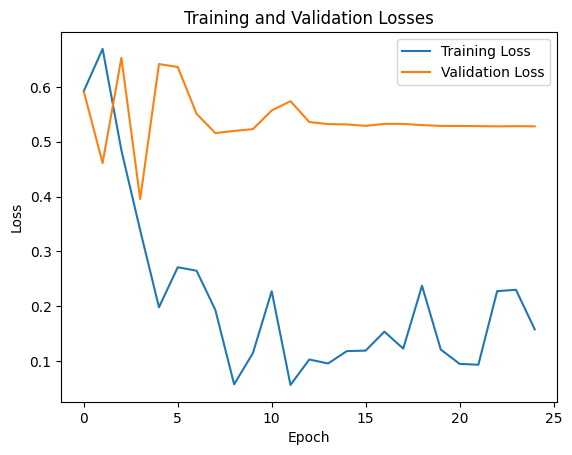

In [41]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Примерно после 12 эпохи функция потерь изменяется не критически, значит можем сократить количество эпох для оптимизации времязатрат без существенной потери в эффективности

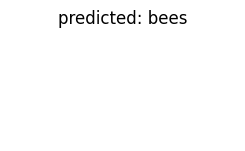

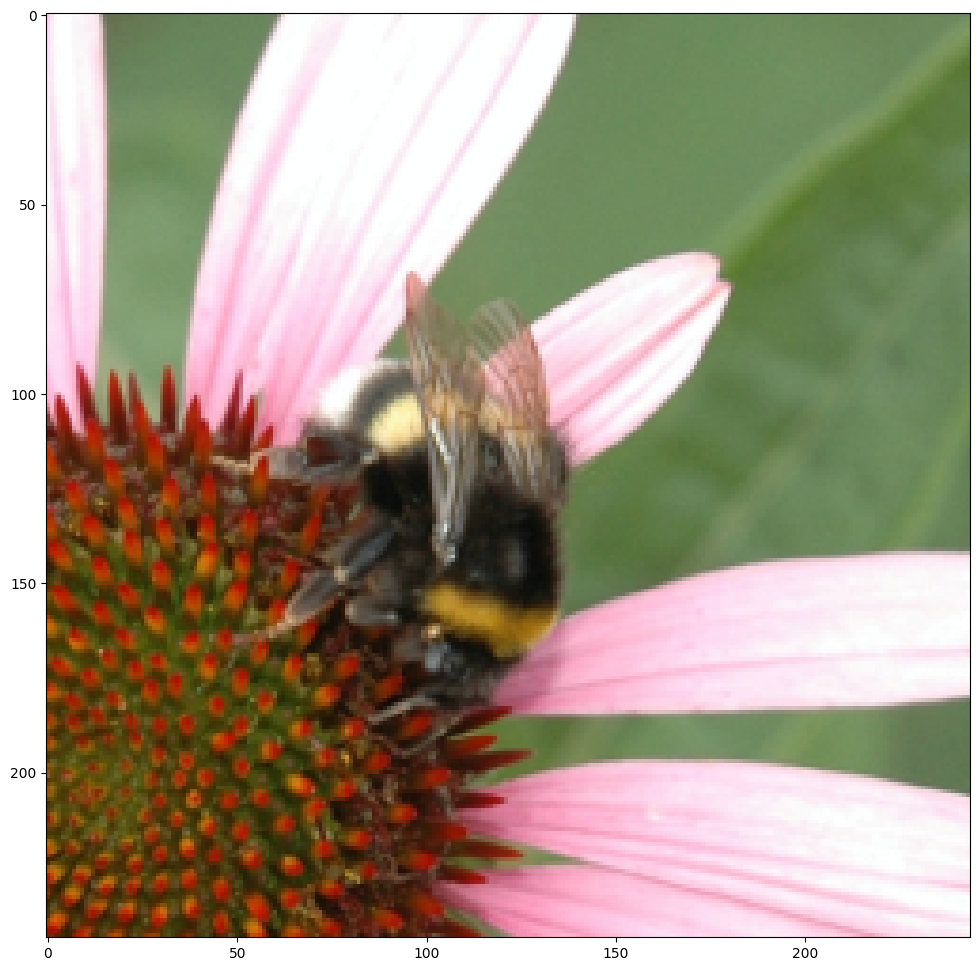

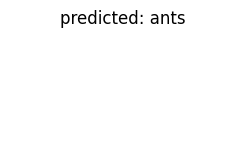

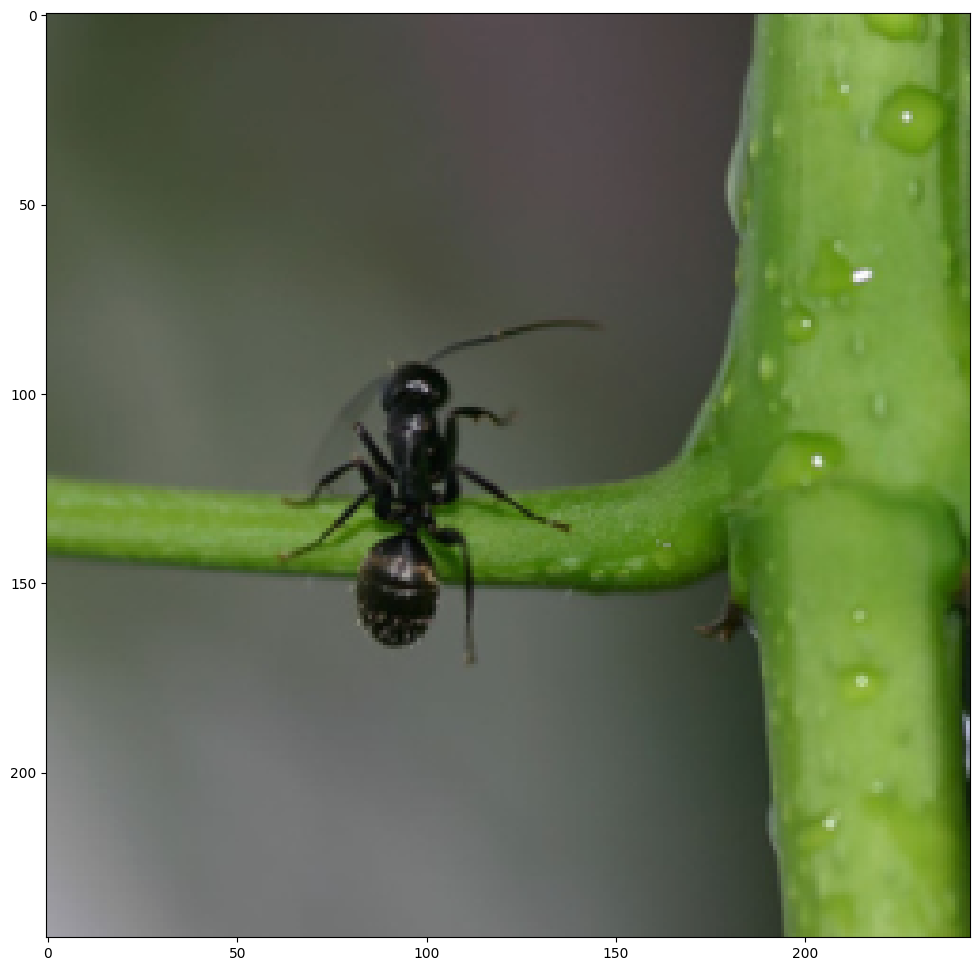

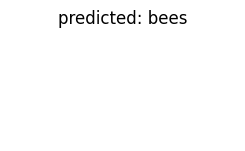

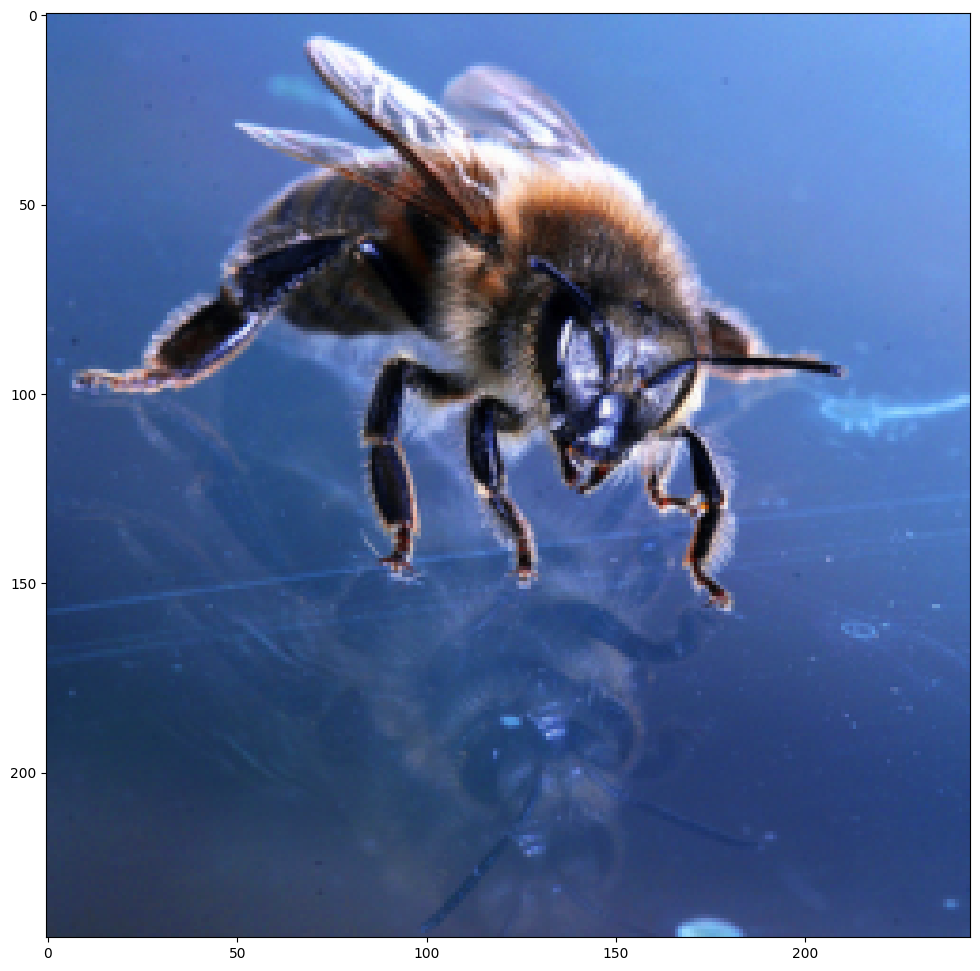

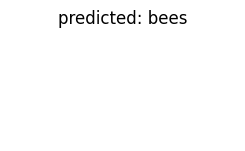

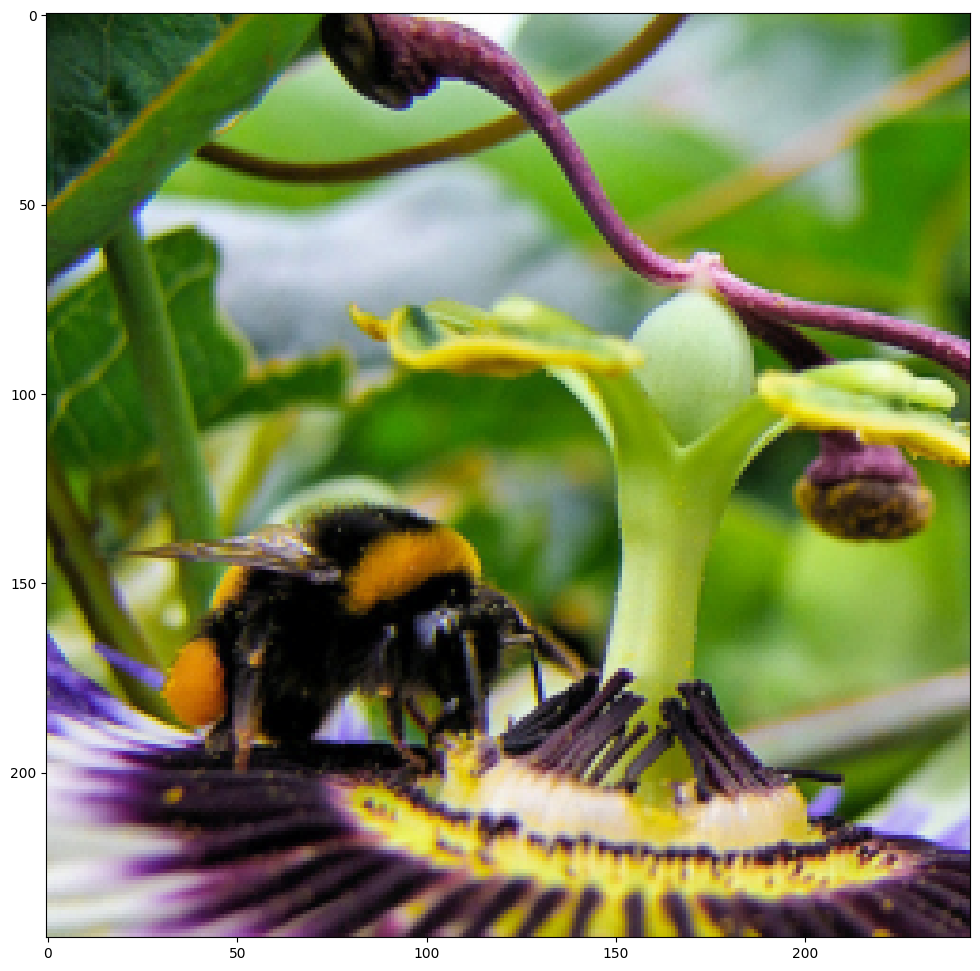

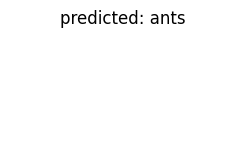

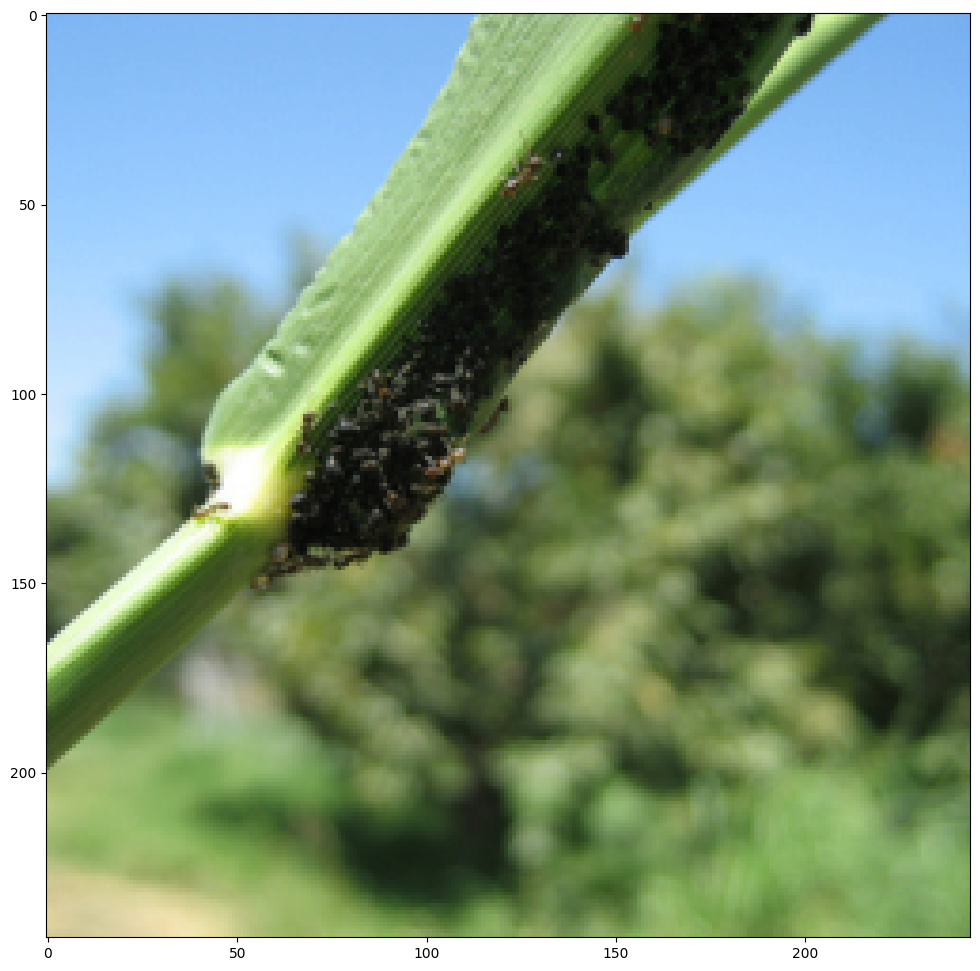

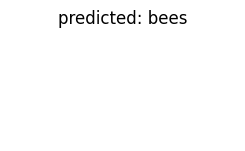

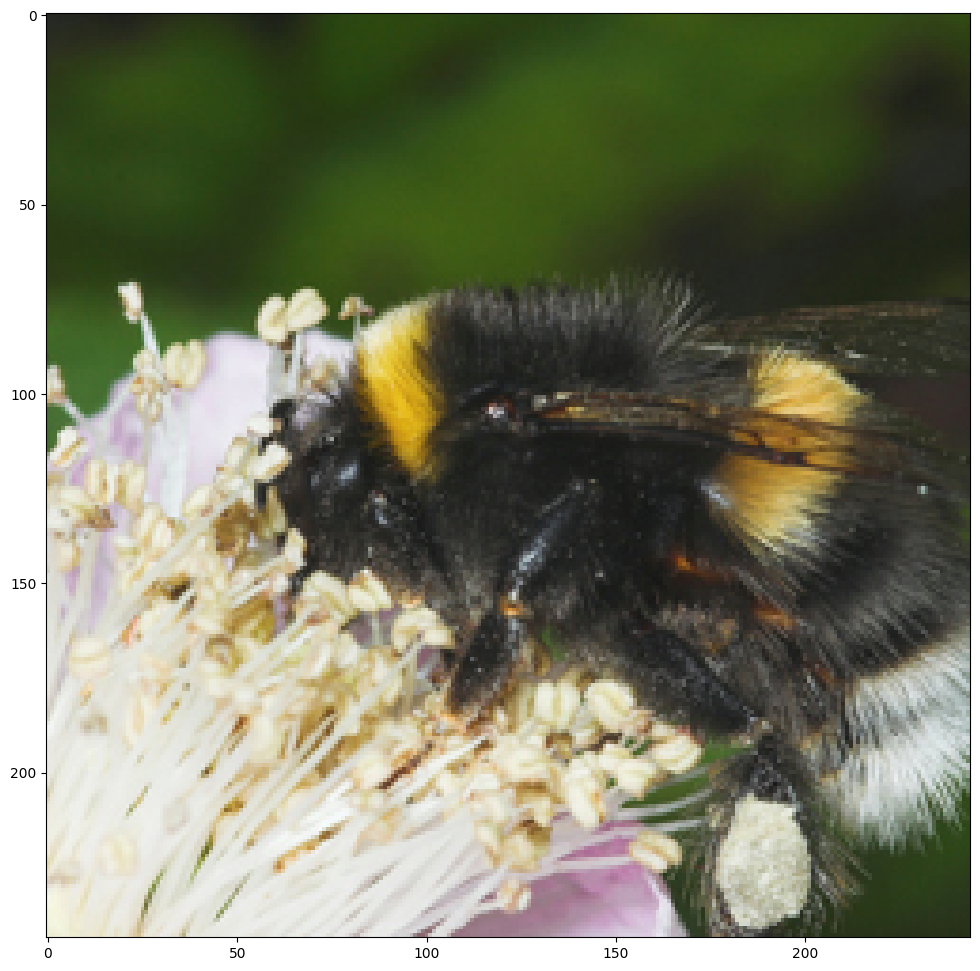

In [43]:
# Используем функцию visualize_model() для визуализации результатов
visualize_model(model_extractor)

In [44]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [45]:
model_extractor.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [46]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9542


Данная нейросеть обучалась дольше всех предыдущих. По времени оно заняло в районе 2-3ч. Прирост в accuracy между AlexNet и VGG16 (обученных способом Feature Extractor) составил примерно +5% в пользу последней.

### **Inception_v3**

In [57]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Определяем устройство (GPU, если доступен, в противном случае CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:

# Загрузка предварительно обученной модели Inception_v3
model_extractor = models.inception_v3(pretrained=True)

# Замораживаем параметры всех слоев модели
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features - это размерность вектора признаков, поступающего на вход FC-слою
num_features = model_extractor.fc.in_features

# Заменяем Fully-Connected (FC) слой на новый линейный классификатор
model_extractor.fc = nn.Linear(num_features, 2)  # Заменяем на 2 класса

# Переносим модель на устройство (GPU, если доступен)
model_extractor = model_extractor.to(device)

# Определяем функцию потерь (loss function)
loss_fn = nn.CrossEntropyLoss()

# Оптимизатор для обучения только классификатора (FC-слоя)
optimizer = optim.SGD(model_extractor.fc.parameters(), lr=0.001, momentum=0.9)

# Уменьшаем learning rate на 0.1 каждые 7 эпох (эвристика)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [59]:

%%time
model_extractor.aux_logits = False
model_extractor, train_losses, val_losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1551 Acc: 0.6475
val Loss: 0.1036 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.1311 Acc: 0.7746
val Loss: 0.0846 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.1268 Acc: 0.7377
val Loss: 0.0973 Acc: 0.8105

Epoch 3/24
----------
train Loss: 0.1157 Acc: 0.7705
val Loss: 0.0665 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.1120 Acc: 0.7951
val Loss: 0.0896 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.1157 Acc: 0.7992
val Loss: 0.0607 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.0969 Acc: 0.8443
val Loss: 0.0552 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.0888 Acc: 0.8320
val Loss: 0.0609 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.1027 Acc: 0.8238
val Loss: 0.0604 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0993 Acc: 0.7910
val Loss: 0.0604 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.1077 Acc: 0.7869
val Loss: 0.0612 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.1010 Acc: 0.8033
val Loss: 0.0561 Acc: 0.9150

Ep

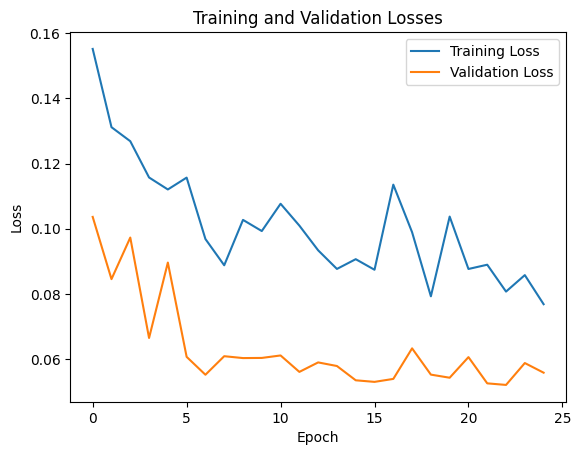

In [60]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


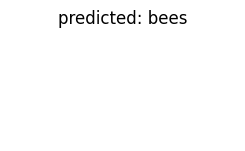

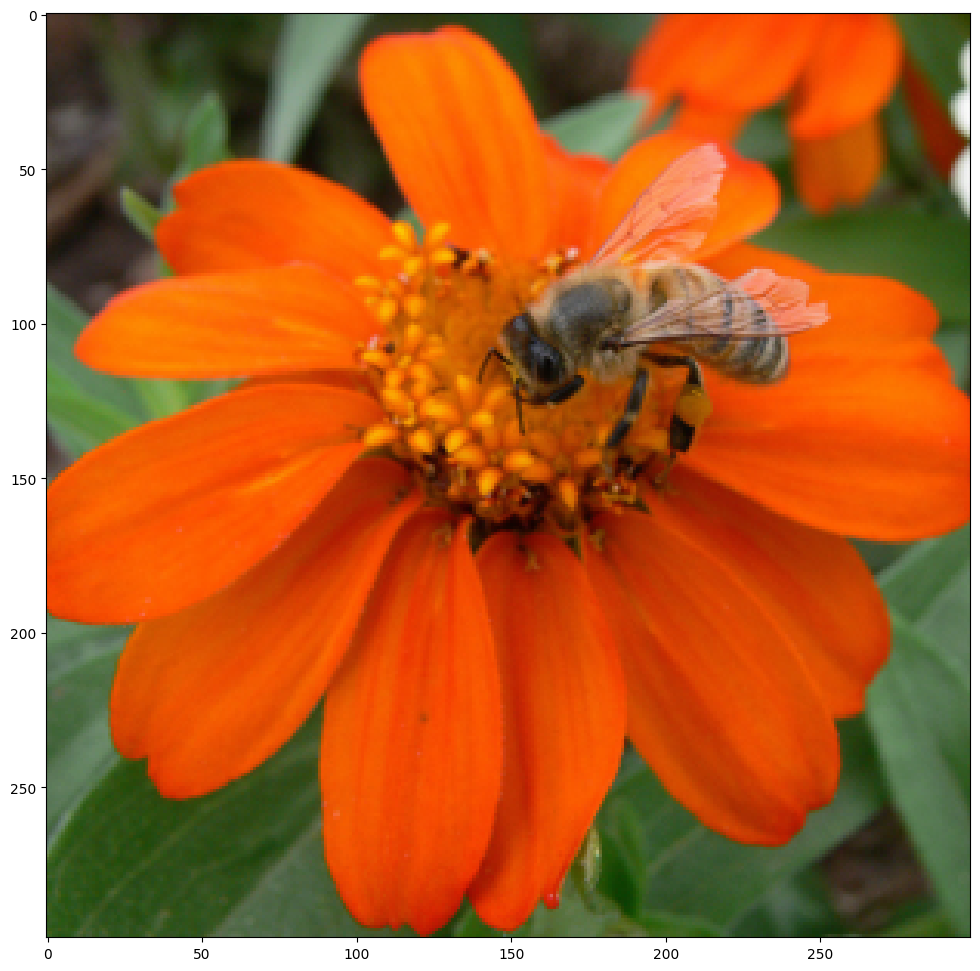

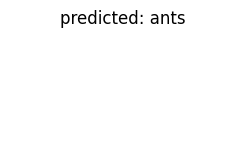

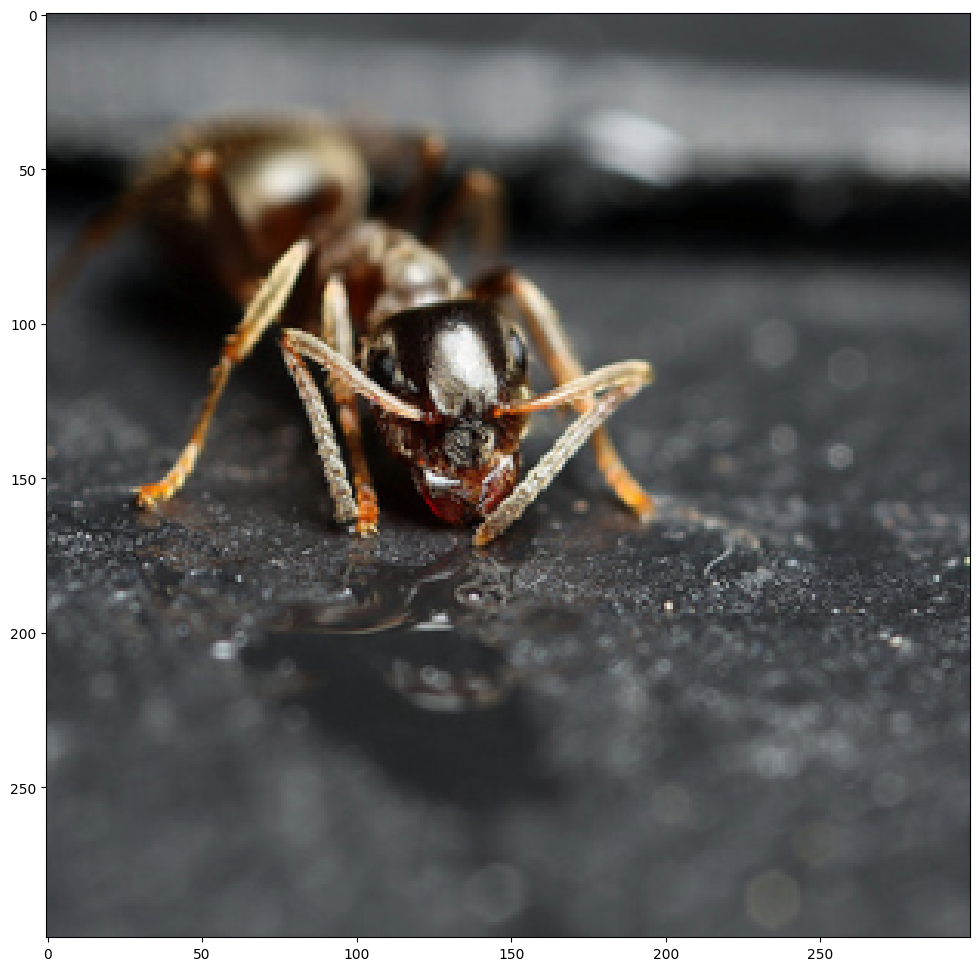

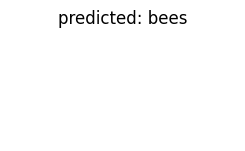

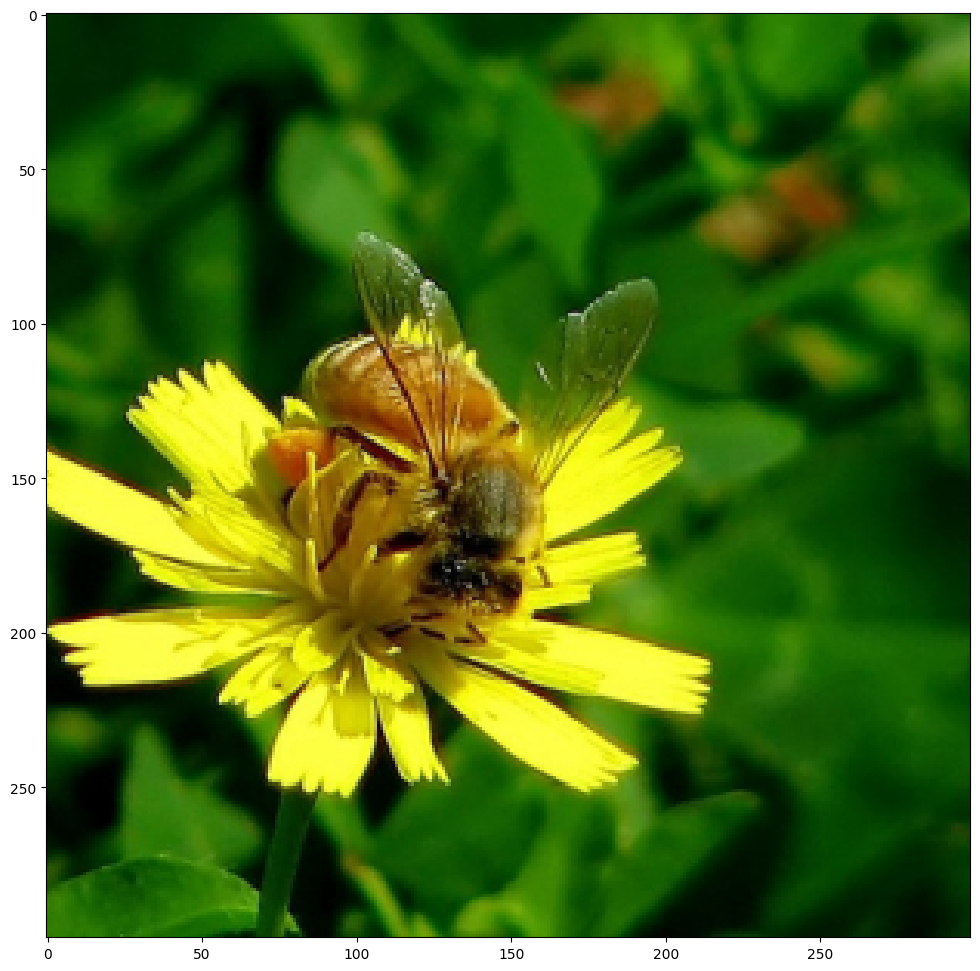

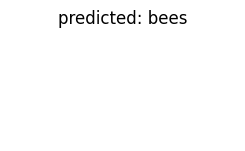

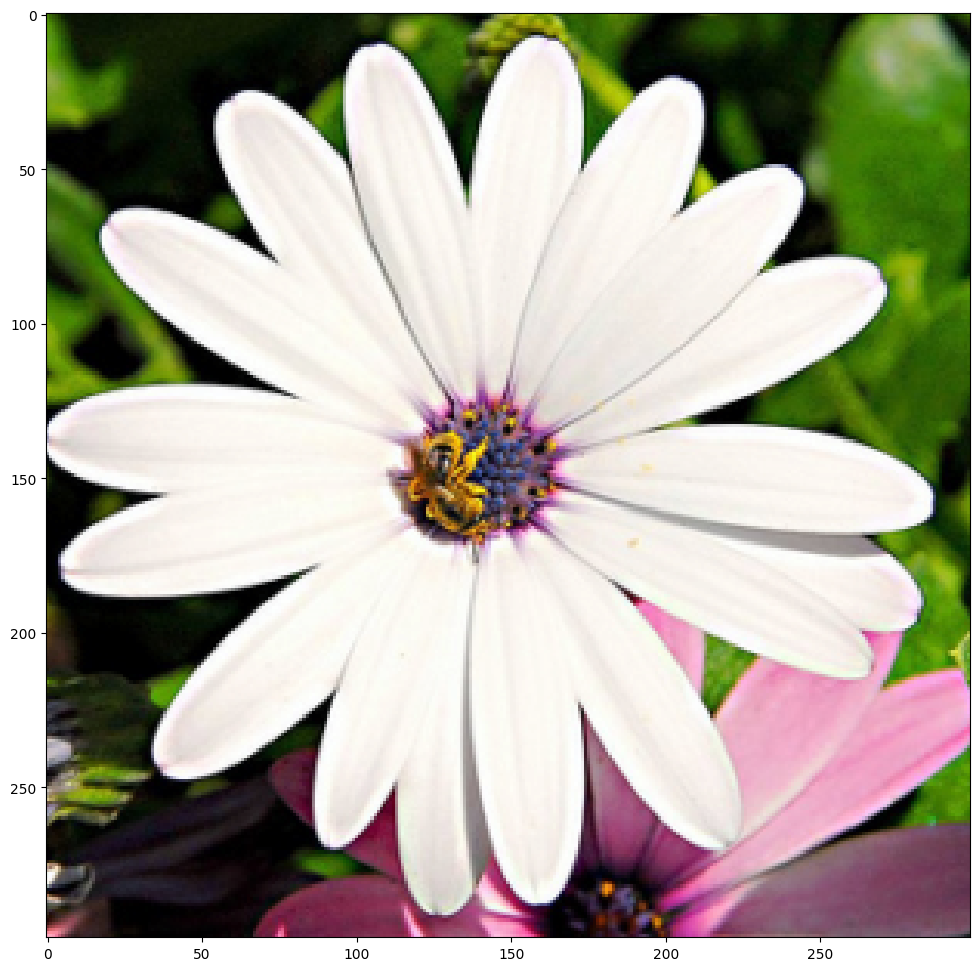

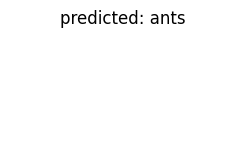

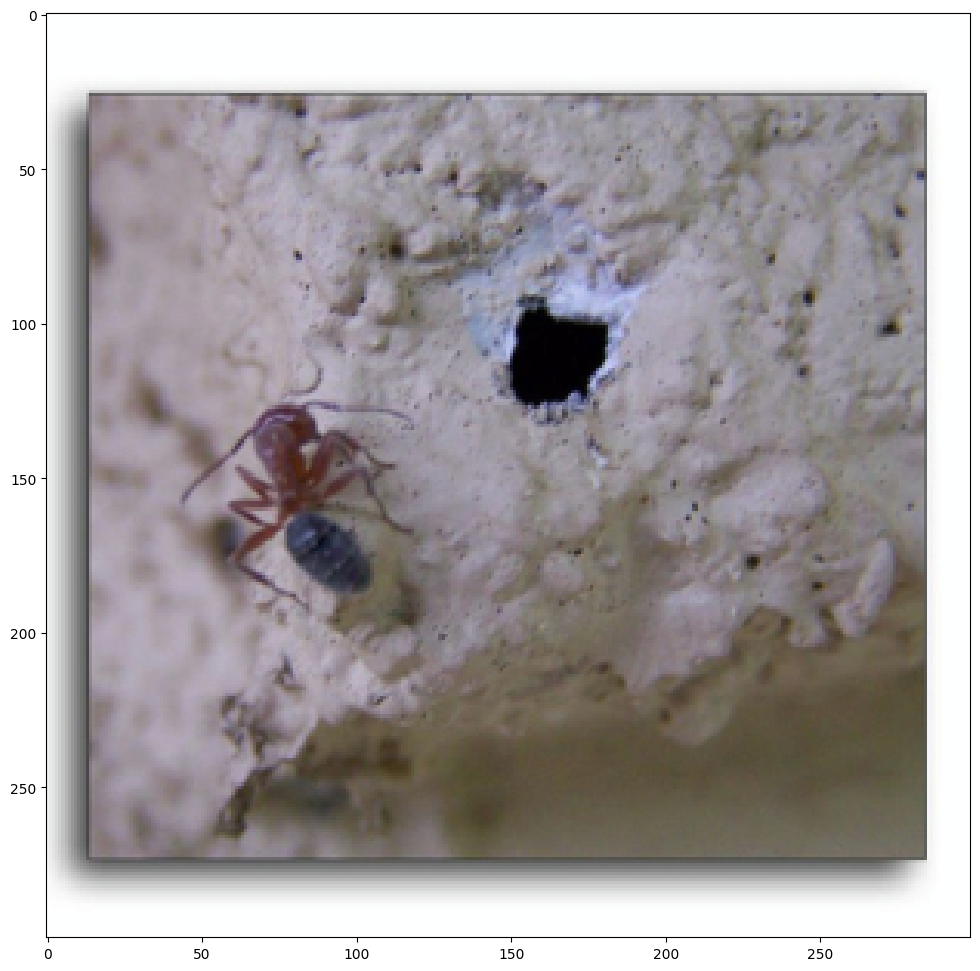

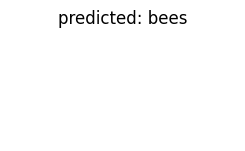

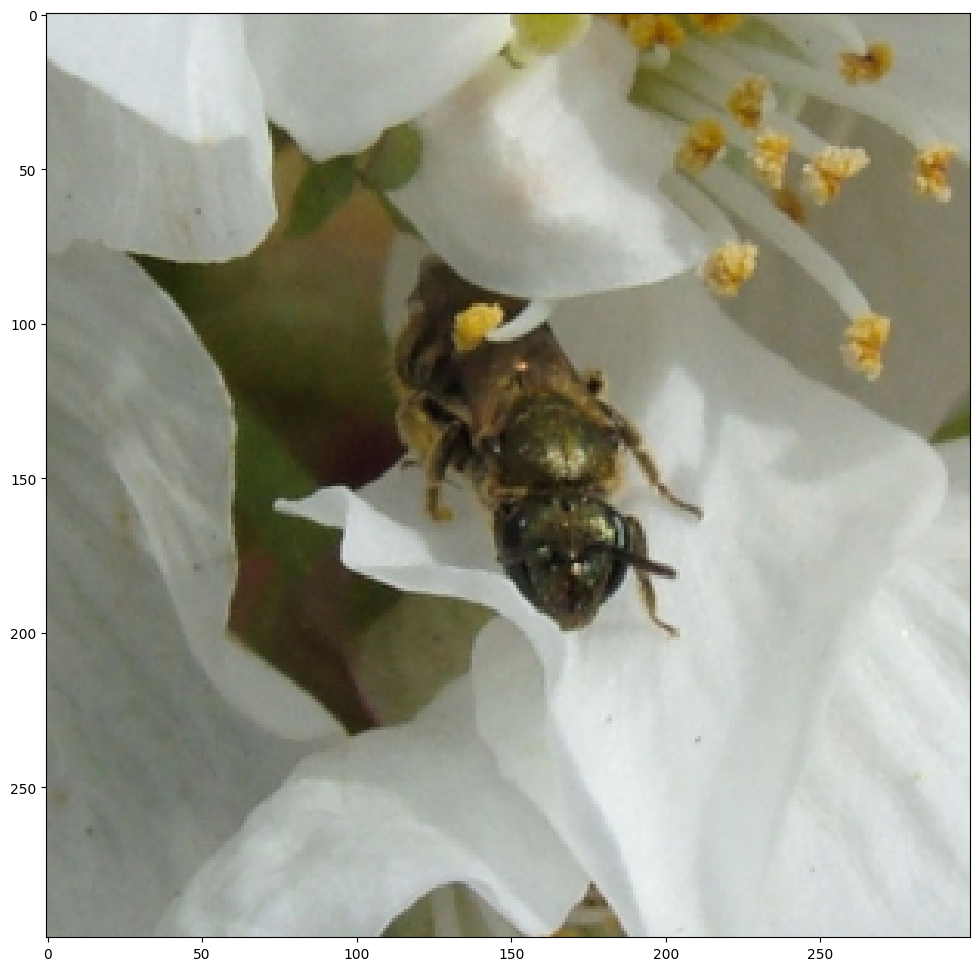

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [61]:
# Используем функцию visualize_model() для визуализации результатов
visualize_model(model_extractor)

In [62]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

In [63]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

<All keys matched successfully>

In [64]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9216


Данная нейросеть обучилась практически в 2 раза быстрее предыдущей. Разница в accuracy_score между Inception_v3 и VGG16 несущественна и составляет приблизительно 3% в пользу последней. Анализируя графики функции потерь обоих нейронок на каждой итерации, прихожу к выводу, что Inception_v3 менее склонна к переобучению.

** Таким образом, на предзагруженном наборе данных нейросеть Inception_v3 являеются оптимальным выбором ввиду "дешевизны" обучения + точности предсказаний**